V4 : Co-kriging sur des données manquantes à la variable Z

In [231]:
import os
import timeit
import  matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import sklearn as sklearn
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from numba import jit
from tqdm import tqdm
from scipy.spatial import distance_matrix
from sklearn.metrics import mean_squared_error

In [232]:
@jit(nopython=True, cache = True)
def alternate_variogram_compiled(X,Y,Z,width,leng,direction = 45,theta_tolerance = 22.5) :
    n=len(X)
    nlag=np.int((leng/width)) # 25, nombre de lag généré, fiw : "Round to nearest integer towards zero"
    dist=[]
    for kk in np.arange(0,nlag,1): # génération de point 0:1:nlag
        dist.append(width+width*(kk)) # pré-allocation des valeurs de distance pour chaque lag
    leng=dist[nlag-1] # distance maximale, valeur du dernier lag
    dev=np.zeros(nlag)
    counts=np.zeros(nlag);    
    n=len(X)
    #theta_tolerance = 22.5
    #direction       = 45
    
    for ii in np.arange(0,n):
        if ii % 10000 == 0 :
            print("Iteration",ii,"/",n)
        for jj in np.arange(ii,n): # 
            xi=X[ii] # xi
            yi=Y[ii]
            zi=Z[ii] # Zi, Observation value
            xj=X[jj] # xi+h, h = distance lag
            yj=Y[jj]
            zj=Z[jj] # Zi+h
            x = xj-xi
            y = yj-yi
            r   = np.sqrt((x)**2+(y)**2) # distance euclidienne
            tht = np.arctan2(y,x) * (180/np.pi)
            
            if tht < 0 :
                tht = 180 + 180-np.absolute(tht) # permet de varier de 0° -> 360°
            
            if(r<leng) and zi != np.nan and zj != np.nan :
                # Ajout de la directionalité 
                
                if (direction + theta_tolerance) < 360 and (direction - theta_tolerance) > 0  :
                    if ((tht >= (direction - theta_tolerance)) and (tht <= (direction + theta_tolerance))) or ((tht >= (direction - theta_tolerance)+180) and (tht <= (direction + theta_tolerance)+180)) :
                        index=np.int((r/width))  # chaque distance/width est associée à un index,
                    # permet de regrouper les valeurs entre elles (paires), ex : distance/width = 2.9-> 2, etc etc
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
                        
                elif (direction + theta_tolerance) > 360 :   
                    if tht >= (direction) or tht <= (0 + (theta_tolerance-(360-direction))) :
                        index=np.int((r/width)) 
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
                else :
                    if (tht >= (360 - np.absolute(theta_tolerance - direction ))) or (tht <= (direction  + theta_tolerance)):
                        index=np.int((r/width))
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
        
            
    gam = np.divide(dev,2*counts)
        
    return dist, counts, gam

# Mise en place du cas synthétique

In [233]:
def fun_Primary(x,y,mu,sigma,size):
    field_z    = np.cos(y)** 2 * np.sin(x**2) +np.random.normal(mu, sigma, (size,  size))  # Fonction 2D test 
    
    return field_z

def fun_Secondary(x,y,mu,sigma,size):
    field_y    = np.cos(y)** 2 * np.sin(x**2) +np.random.normal(mu, sigma, (size,  size)) *np.exp(x/2)  # Fonction 2D test 

    
    return field_y


In [234]:
def function_circle(x,y,z,rmax = 20, roll = 3, delta = 1) :
    """
    Fonction qui choisi aléatoirement des zones de forme circulaire, renvoi un DataFrame 
    """
    ## Initialisation des constantes/ DataFrame
    df = pd.DataFrame()
    df["X"] = x.reshape(-1)
    df["Y"] = y.reshape(-1)
    df["Z"] = z.reshape(-1)
    mask_area = pd.DataFrame()
    mask_area["X"] = x.reshape(-1)
    mask_area["Y"] = y.reshape(-1)
    # Initialisation des matrices
    x_array  = np.empty(0)
    y_array  = np.empty(0)
    z_array  = np.empty(0)
    x0_array = np.empty(0)
    y0_array = np.empty(0)
    # rng, random generator 
    rng = np.random.default_rng()
    for i in np.arange(roll) : 
        selected_location =  rng.choice(mask_area.dropna(axis = 0))
        x0_array = np.append(x0_array,selected_location[0])
        y0_array = np.append(y0_array,selected_location[1])
        
        # Distance
        df['r'] = np.sqrt((x0_array[i]-df["X"])**2 + (y0_array[i]-df["Y"])**2)
        # Zone en dehors du cercle
        exp = "r < " + str(rmax * 2)
        mask_area.loc[df.query(exp).index.array] = np.nan
        
        # Zone situé dans le cercle 
        exp = "r < " + str(rmax)
        x_array = np.append(x_array,df.query(exp)["X"].values)
        y_array = np.append(y_array,df.query(exp)["Y"].values)
        z_array = np.append(z_array,df.query(exp)["Z"].values)
    
    df = pd.DataFrame()
    df["X"] = x_array
    df["Y"] = y_array
    df["original_z"] = z_array
    df.sort_values(by = ["X","Y"],ascending=False)
    df = df.dropna(axis = 0)
    df["Primary"] = (df["original_z"] - df["original_z"].mean()) / df["original_z"].std()
    
 
    return df, x0_array, y0_array

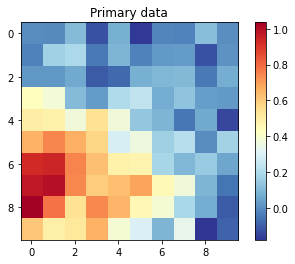

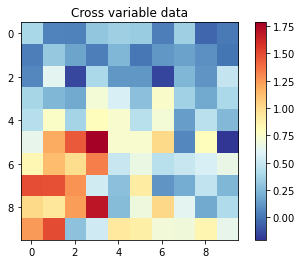

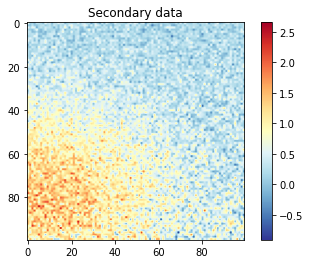

In [235]:
# Primary Data générées (Z)
x_original,y_original = np.mgrid[0:0.5 * np.pi:10j,0:0.5 * np.pi:10j]
# Secondary Data générées (Y)
xx_original, yy_original = np.mgrid[0:0.5 * np.pi:100j, 0:0.5 * np.pi:100j]
# coordinates from 1 -> 100 
xx_z, yy_z  = np.mgrid[0:100:10, 0:100:10]
xx_y, yy_y = np.mgrid[0:100, 0:100]

# Setup Random Noise
np.random.seed(21)
mu_z, sigma_z = 0, 0.1
mu_y, sigma_y = 0.2, 0.2

#Primary Data
_field_z    = fun_Primary(x_original,y_original,mu_z,sigma_z,size = 10)
_field_zy   = fun_Secondary(x_original,y_original,mu = mu_y,sigma = sigma_y,size = 10) 


#Secondary Data
_field_y   = fun_Secondary(xx_original,yy_original,mu = mu_y,sigma = sigma_y,size = 100)

# Quick view 
figg = plt.imshow(_field_z, cmap='RdYlBu_r')
plt.title('Primary data')
plt.colorbar(figg)
plt.show()
figg = plt.imshow(_field_zy, cmap='RdYlBu_r')
plt.title('Cross variable data')
plt.colorbar(figg)
plt.show()
figg = plt.imshow(_field_y, cmap='RdYlBu_r')
plt.title('Secondary data')
plt.colorbar(figg)



In [342]:
# Conversion en dataframe
Primary = pd.DataFrame()
Primary["X"] = xx_z.reshape(-1)
Primary["Y"] = yy_z.reshape(-1)
Primary["original_z"] = _field_z.reshape(-1)
Primary["original_zy"] = np.nan
original_std_z = Primary["original_z"].std()
original_mean_z = Primary["original_z"].mean()
Primary["Primary"] = (Primary["original_z"] - Primary["original_z"].mean()) / Primary["original_z"].std()
Primary["Secondary"] = np.nan

In [343]:
# Conversion en dataframe
Secondary = pd.DataFrame()
Secondary["X"] = xx_y.reshape(-1)
Secondary["Y"] = yy_y.reshape(-1)
Secondary["original_y"] = _field_y.reshape(-1)
original_std_z = Secondary["original_y"].std()
original_mean_z = Secondary["original_y"].mean()
Secondary["Secondary"] = (Secondary["original_y"] - Secondary["original_y"].mean()) / Secondary["original_y"].std()

In [344]:
rmax = 2
np.random.seed(3)
Primary, x0_array, y0_array = function_circle(xx_z,yy_z,_field_z,rmax,roll = 10,delta = 10)
Primary["original_zy"] = np.nan

for x,y,zy_value in zip(Secondary["X"].values,Secondary["Y"].values,Secondary["original_y"]) :
    exp = "X == " + str(x) + " and Y == " + str(y)
    index = Primary.query(exp).index.array
    Primary.loc[index,'original_zy'] = zy_value
Primary["Secondary"] = (Primary["original_zy"] - Primary["original_zy"].mean()) / Primary["original_zy"].std()

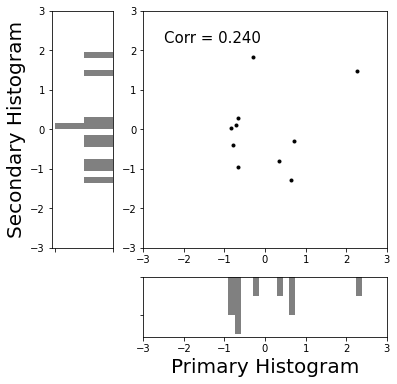

In [345]:
# Set up the axes with gridspec
corr = np.corrcoef(Primary["Primary"], Primary["Secondary"])[0, 1]
vlim = (-3, 3)
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(Primary["Primary"], Primary["Secondary"], "ok", markersize=3)
main_ax.set_xlim(vlim)
main_ax.set_ylim(vlim)
main_ax.text(-2.5, 2.2,
    "Corr = {0:.3f}".format(
        np.corrcoef(Primary["Primary"], Primary["Secondary"])[0, 1]
    ),
    size=15
)

# histogram on the attached axes
x_hist.hist(
    Primary["Primary"],
    40,
    histtype="stepfilled",
    label="Primary",
    orientation="vertical",
    color="gray",
    range=vlim,
)
x_hist.set_xlabel("Primary Histogram", size=20)
x_hist.invert_yaxis()


y_hist.hist(
    Primary["Secondary"],
    40,
    histtype="stepfilled",
    orientation="horizontal",
    color="gray",
    range=vlim,
)
y_hist.set_ylabel("Secondary Histogram", size=20)
y_hist.invert_xaxis()


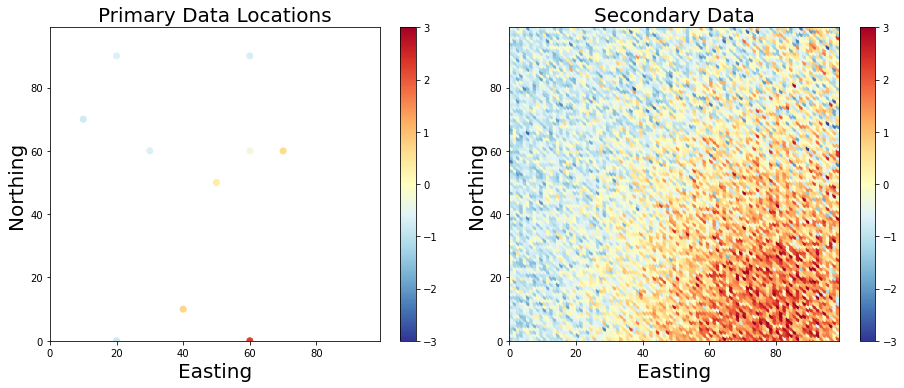

In [346]:
f, ax = plt.subplots(1, 2, figsize=(13, 5.5))
img0 = ax[0].scatter(Primary["X"], Primary["Y"], c=Primary["Primary"].values,
                     vmin = -3,vmax = 3,cmap = "RdYlBu_r")
ax[0].set_title("Primary Data Locations", size=20)
ax[0].set_xlabel("Easting", size=20)
ax[0].set_ylabel("Northing", size=20)

img1 = ax[1].scatter(Secondary["X"], Secondary["Y"], c=Secondary["Secondary"].values,
                     vmin = -3,vmax = 3,cmap = "RdYlBu_r")
ax[1].set_xlabel("Easting", size=20)
ax[1].set_ylabel("Northing", size=20)
ax[1].set_title("Secondary Data", size=20)
f.colorbar(img0, ax=ax[0])
f.colorbar(img1, ax=ax[1])
plt.tight_layout()

ax[0].set_xlim([xx_y.min(),xx_y.max()])
ax[0].set_ylim([yy_y.min(),yy_y.max()])
ax[1].set_xlim([xx_y.min(),xx_y.max()])
ax[1].set_ylim([yy_y.min(),yy_y.max()])
plt.show()


# Variogrammes

## Secondary 

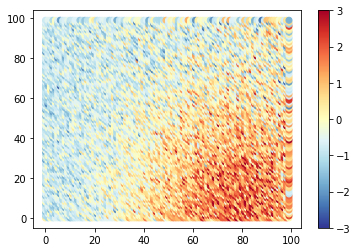

In [347]:
img1 = plt.scatter(Secondary["X"], Secondary["Y"], c=Secondary["Secondary"].values,
                   vmin = -3,vmax = 3,cmap = "RdYlBu_r")
plt.colorbar(img1)

In [348]:
X = Secondary["X"].astype(float).values
Y = Secondary["Y"].astype(float).values
Z = Secondary["Secondary"].astype(float).values
original_std_y = Secondary["original_y"].std()
original_mean_y = Secondary["original_y"].mean()
print("size X :", len(X))
print("size Y :", len(Y))
print("size Z :", len(Z))

size X : 10000
size Y : 10000
size Z : 10000


In [349]:
L=(max(X)-min(X))*1/2 # distance maximale
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 1.0 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 99.0  	 Distance maximale retenue : 49.5
nlag : 49


In [350]:
direction = [0,45,90,135] 
angle_tolerance = 22.5
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 10000
direction done : 0
RUN TIME : 1.4459792999987258
Iteration 0 / 10000
direction done : 45
RUN TIME : 1.4300698000006378
Iteration 0 / 10000
direction done : 90
RUN TIME : 1.3932464000026812
Iteration 0 / 10000
direction done : 135
RUN TIME : 1.4230611000020872


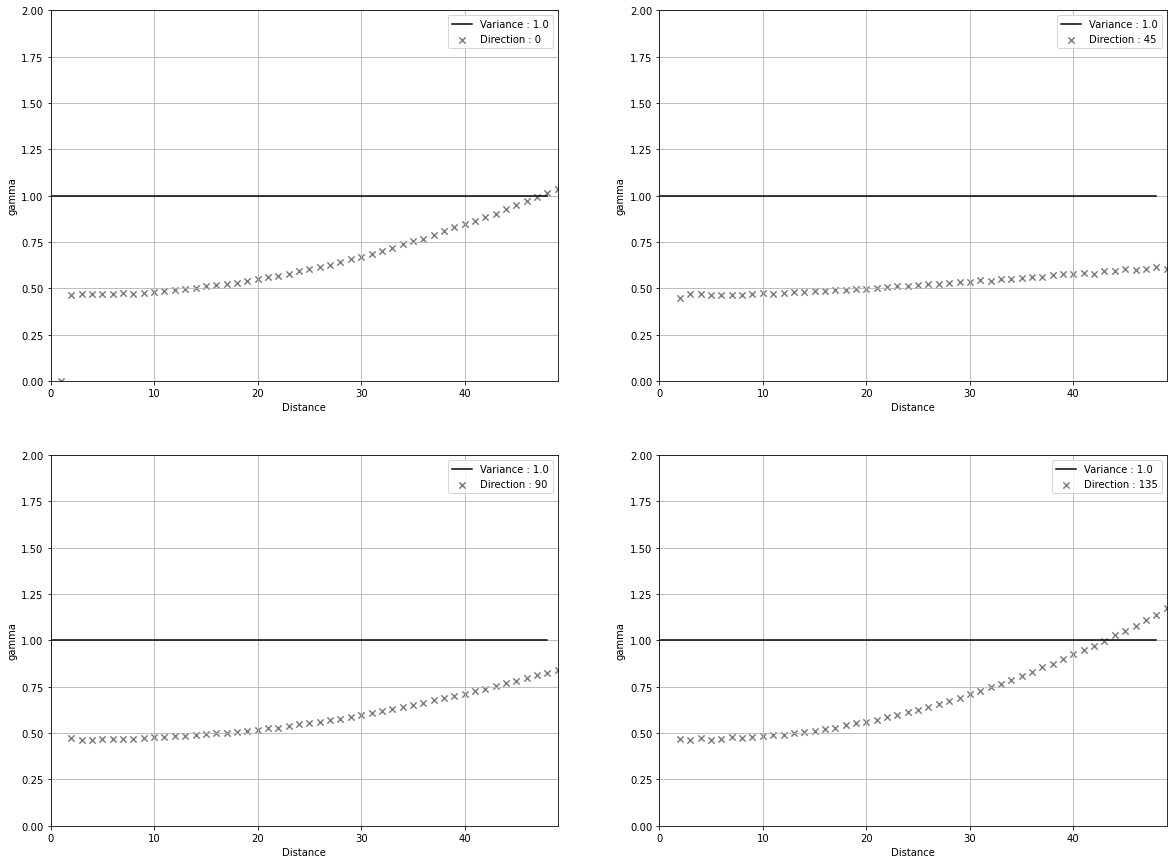

In [351]:
var_y = float("{:.2f}".format(Z.var()))
ones = np.ones(shape=(int(L))) * var_y
H    = np.arange(0,int(L))
fig,ax=plt.subplots(2,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].plot(H,ones,"black", label = "Variance : " + str(var_y))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    ax[ii,jj].set_ylim([0,2])
    ax[ii,jj].set_xlim([0,max(dist_dir)])
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0

In [352]:
## MAJOR DIRECTION / MINOR DIRECTION :
Direction = {"Major" : 0,
            "Minor" : 90,
            }

In [353]:
for direction in dist :
    if direction == Direction["Major"] :
        index_major = np.ones((1,len(dist[direction])))
        dist_major  = dist[direction]
        gam_major   = gam[direction]
        count_major = counts[direction]
    elif direction == Direction["Minor"] :
        index_minor = np.ones((1,len(dist[direction]))) * 2
        dist_minor  = dist[direction]
        gam_minor   = gam[direction]
        count_minor = counts[direction]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_2 = pd.DataFrame()
varc_2["Lag Distance"] = dist_array
varc_2["Number of Pairs"] = count_array
varc_2["Variogram Value"] = gam_array
varc_2["Variogram Index"] = index_array 
varc_2 = varc_2.loc[varc_2["Variogram Value"] != 0]
varc_2 = varc_2.dropna(axis = 0)

In [354]:
varc_2.head()

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
1,2.0,9900.0,0.465788,1.0
2,3.0,9800.0,0.469455,1.0
3,4.0,28906.0,0.467375,1.0
4,5.0,28608.0,0.467069,1.0
5,6.0,46930.0,0.467651,1.0


In [355]:
varc_2.head()

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
1,2.0,9900.0,0.465788,1.0
2,3.0,9800.0,0.469455,1.0
3,4.0,28906.0,0.467375,1.0
4,5.0,28608.0,0.467069,1.0
5,6.0,46930.0,0.467651,1.0


In [356]:
#Secondary.to_csv("cas_synthetique.csv")

## Primary 

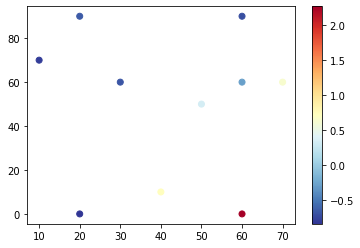

In [357]:
img0 = plt.scatter(Primary["X"], Primary["Y"], c=Primary["Primary"].values,cmap = "RdYlBu_r")
plt.colorbar(img0)

In [358]:
X = Primary["X"].astype(float).values
Y = Primary["Y"].astype(float).values
Z = Primary["Primary"].astype(float).values
original_std_y = Primary["original_z"].std()
original_mean_y = Primary["original_z"].mean()
print("size X :", len(X))
print("size Y :", len(Y))
print("size Z :", len(Z))

size X : 10
size Y : 10
size Z : 10


#### estimation de la distance maximale à retenir

In [359]:
distance_variable = 0
for i in range(0,len(X)) :
    for j in range (0,len(X)) :
        x = X[i] - X[j]
        y = Y[i] - Y[j]
        dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
        if dist_temp > distance_variable :
            distance_variable = dist_temp
        
print("distance maximale:", distance_variable)

distance maximale: 98.48857801796105


In [360]:
L=(max(X)-min(X))*2/3 # distance maximale
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 10.0 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 70.0  	 Distance maximale retenue : 40.0
nlag : 4


In [363]:
direction = [0,45,90,135]
angle_tolerance = 90
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 10
direction done : 0
RUN TIME : 1.0951726999992388
Iteration 0 / 10
direction done : 45
RUN TIME : 0.00020619999850168824
Iteration 0 / 10
direction done : 90
RUN TIME : 0.0001973999969777651
Iteration 0 / 10
direction done : 135
RUN TIME : 0.00019710000196937472


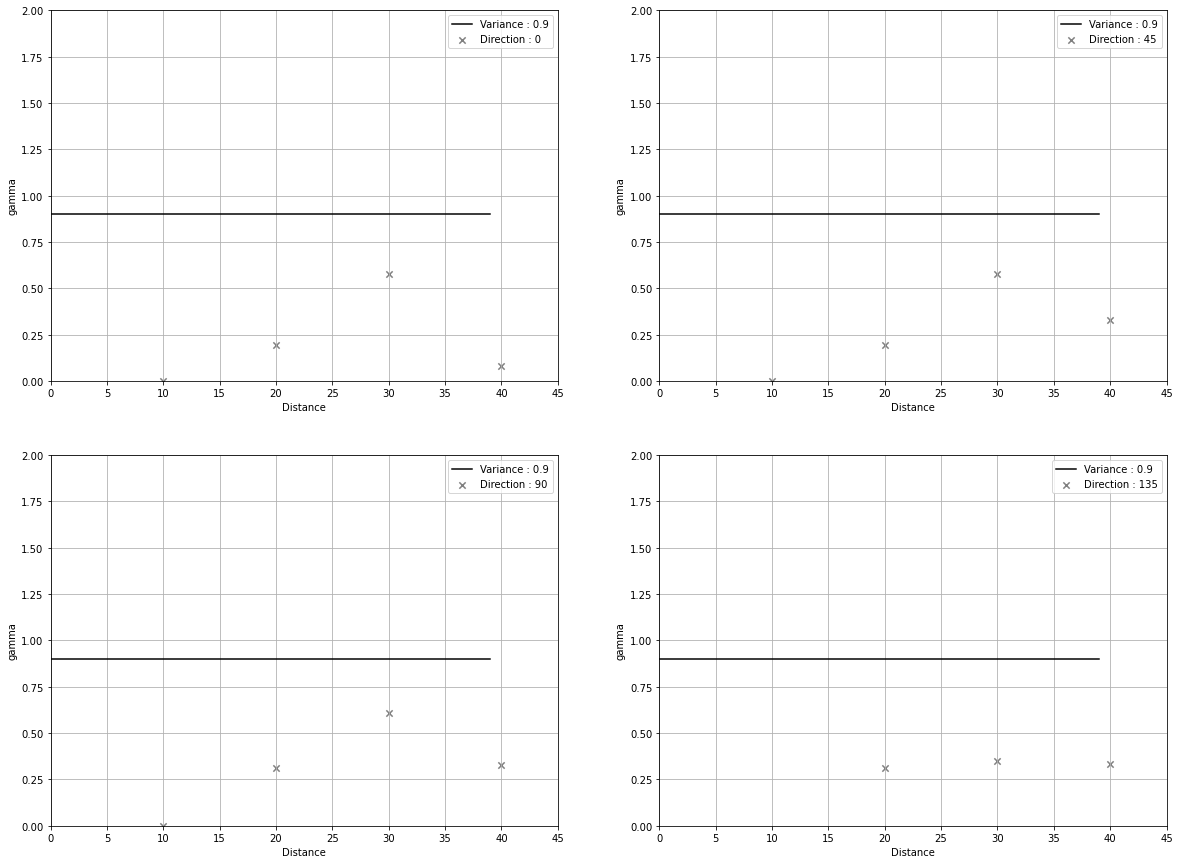

In [364]:
var_z = float("{:.2f}".format(Z.var()))
ones = np.ones(shape=(int(L))) * var_z
H    = np.arange(0,int(L))
fig,ax=plt.subplots(2,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].plot(H,ones,"black", label = "Variance : " + str(var_z))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    ax[ii,jj].set_ylim([0,2])
    ax[ii,jj].set_xlim([0,max(dist_dir)+5])
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0

In [365]:
## MAJOR DIRECTION / MINOR DIRECTION :
Direction = {"Major" : 0,
            "Minor" : 90,
            }

In [367]:
for direction in dist :
    if direction == Direction["Major"] :
        index_major = np.ones((1,len(dist[direction])))
        dist_major  = dist[direction]
        gam_major   = gam[direction]
        count_major = counts[direction]
    elif direction == Direction["Minor"] :
        index_minor = np.ones((1,len(dist[direction]))) * 2
        dist_minor  = dist[direction]
        gam_minor   = gam[direction]
        count_minor = counts[direction]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_1 = pd.DataFrame()
varc_1["Lag Distance"] = dist_array
varc_1["Number of Pairs"] = count_array
varc_1["Variogram Value"] = gam_array
varc_1["Variogram Index"] = index_array 
varc_1 = varc_1.loc[varc_1["Variogram Value"] != 0]
varc_1 = varc_1.dropna(axis = 0)

In [368]:
varc_1

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
1,20.0,1.0,0.194874,1.0
2,30.0,3.0,0.579637,1.0
3,40.0,2.0,0.082150,1.0
5,20.0,2.0,0.311585,2.0
6,30.0,4.0,0.608221,2.0
7,40.0,3.0,0.329607,2.0


In [265]:
Primary.to_csv("./cas synthetique/cas_synthetique_primary.csv")

## Cross 

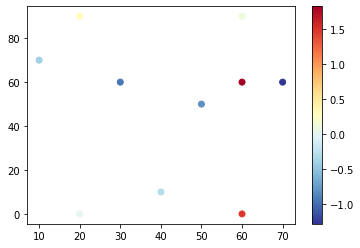

In [370]:
img0 = plt.scatter(Primary["X"], Primary["Y"], c=Primary["Secondary"].values,cmap = "RdYlBu_r")
plt.colorbar(img0)

In [371]:
X = Primary["X"].astype(float).values
Y = Primary["Y"].astype(float).values
Z = Primary["Secondary"].astype(float).values
print("size X :", len(X))
print("size Y :", len(Y))
print("size Z :", len(Z))

size X : 10
size Y : 10
size Z : 10


#### estimation de la distance maximale à retenir

In [372]:
distance_variable = 0
for i in range(0,len(X)) :
    for j in range (0,len(X)) :
        x = X[i] - X[j]
        y = Y[i] - Y[j]
        dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
        if dist_temp > distance_variable :
            distance_variable = dist_temp
        
print("distance maximale:", distance_variable)

distance maximale: 98.48857801796105


In [373]:
L=(max(X)-min(X))*2/3 # distance maximale
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 10.0 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 70.0  	 Distance maximale retenue : 40.0
nlag : 4


In [376]:
direction = [0,45,90,135]
angle_tolerance = 90
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 10
direction done : 0
RUN TIME : 0.000531600002432242
Iteration 0 / 10
direction done : 45
RUN TIME : 0.0001951000012923032
Iteration 0 / 10
direction done : 90
RUN TIME : 0.00020400000357767567
Iteration 0 / 10
direction done : 135
RUN TIME : 0.00041459999920334667


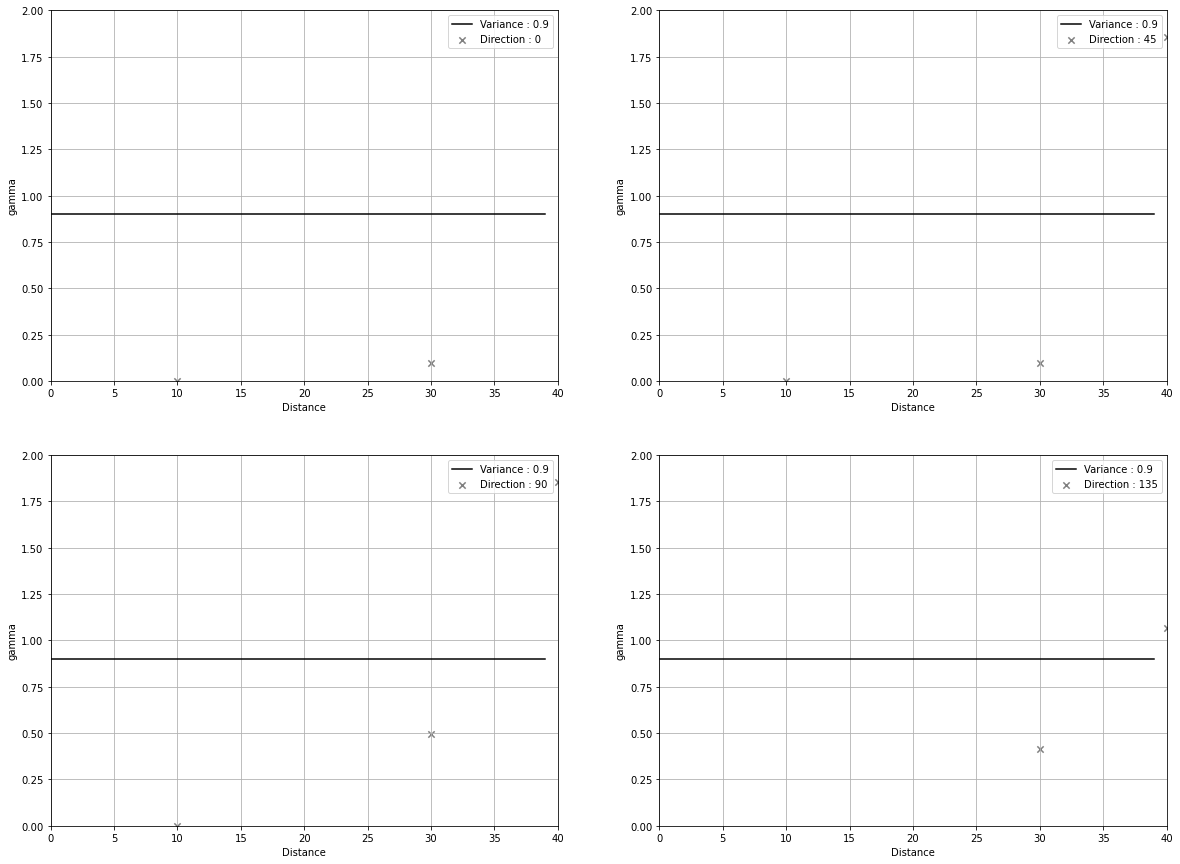

In [377]:
var_z = float("{:.2f}".format(Z.var()))
ones = np.ones(shape=(int(L))) * var_z
H    = np.arange(0,int(L))
fig,ax=plt.subplots(2,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].plot(H,ones,"black", label = "Variance : " + str(var_z))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    ax[ii,jj].set_ylim([0,2])
    ax[ii,jj].set_xlim([0,max(dist_dir)])
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0

In [378]:
## MAJOR DIRECTION / MINOR DIRECTION :
Direction = {"Major" : 0,
            "Minor" : 90,
            }

In [379]:
for direction in dist :
    if direction == 0 :
        index_major = np.ones((1,len(dist[direction])))
        dist_major  = dist[direction]
        gam_major   = gam[direction]
        count_major = counts[direction]
    elif direction == 90 :
        index_minor = np.ones((1,len(dist[direction]))) * 2
        dist_minor  = dist[direction]
        gam_minor   = gam[direction]
        count_minor = counts[direction]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_3 = pd.DataFrame()
varc_3["Lag Distance"] = dist_array
varc_3["Number of Pairs"] = count_array
varc_3["Variogram Value"] = gam_array
varc_3["Variogram Index"] = index_array 
varc_3 = varc_3.loc[varc_3["Variogram Value"] != 0]
varc_3 = varc_3.dropna(axis = 0)

In [381]:
varc_3

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
1,20.0,1.0,3.458696,1.0
2,30.0,3.0,0.099825,1.0
3,40.0,2.0,2.648825,1.0
5,20.0,2.0,4.133107,2.0
6,30.0,4.0,0.497548,2.0
7,40.0,3.0,1.856423,2.0


# Correlogramme Model

In [382]:
def covar(t, d, r):
    h = d / r
    if t == 1:  # Spherical
        c = (1 - h * (1.5 - 0.5 * np.square(h)))
        c[h > 1] = 0
    elif t == 2:  # Exponential
        c = (np.exp(-3 * h))
    elif t == 3:  # Gaussian
        c = (np.exp(-3 * np.square(h)))
    return c

In [383]:
def Rot_Mat(Azimuth, a_max, a_min):
    theta = (Azimuth / 180.0) * np.pi
    Rot_Mat = np.dot(
        np.array([[1 / a_max, 0], [0, 1 / a_min]]),
        np.array(
            [
                [np.cos(theta), np.sin(theta)],
                [-np.sin(theta), np.cos(theta)],
            ]
        ),
    )
    return Rot_Mat

In [384]:
## Define some matrices for storing variogram values
LENGTH = 150
cy = np.zeros(shape=(LENGTH + 1))
cz_True = np.zeros(shape=(LENGTH + 1))
cr = np.zeros(shape=(LENGTH + 1))
cz = np.zeros(shape=(LENGTH + 1))
czy = np.zeros(shape=(LENGTH + 1))
H = np.zeros(shape=(LENGTH + 1))
ones = np.zeros(shape=(LENGTH + 1))
Sill_vals = [1,1,corr] ## !!

### Plottting labels 
colors = ["Red", "Green","Blue"]
labels_2 = ["$\u03C1_{z}$", "$\u03C1_{y}$", "$\u03C1_{zy}$"]

Corr_labels = [
    "Primary Correlogram",
    "Secondary Correlogram",
    "Cross Correlogram"]

labels_1 = [
    "$\hat{\u03C1_{z}}$",
    "$\hat{\u03C1_{y}}$",
    "$\hat{\u03C1_{zy}}$",
]
labels_MM = [
    "$\u03C1_{z_{Model}}$",
    "$\u03C1_{y_{Model}}$",
    "$\u03C1_{z_{MMII}}$",
]

Cross_ones = np.zeros(shape=(101))


## Primary

In [385]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_alternate(h1, h2, k,dict_C_Z,nstruct = 1,Azimuth = 0):
    C = []
    #nstruct = 1
    vtype = dict_C_Z["vtype"]
    a_max = dict_C_Z["a_max"]
    a_min = dict_C_Z["a_min"] 
    cc = dict_C_Z["cc"]
    #Azimuth = 45
    c = 0
    #print(vtype,a_max,a_min,cc)
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i] 
    return c

In [386]:
def optimize_RMSE_Z_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] à la Sill_value
    gamma= b*spherical(a_min,a_max)
    pour un modèle à plusieur couche => inserer en tant que list : a_max = [a_max1,a_max2]
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    if len(x0) == 3 :
        a_max_z_0 = [x[0]]         # range
        a_min_z_0 = [x[1]]
        cc_z_0 = [x[2]]            # effet pépite
        MODEL_value = [args[2]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_z_0 = x[0::3]        # range
        a_min_z_0 = x[1::3]
        cc_z_0 = x[2::3]           # effet pépite
        MODEL_value = args[2::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_primary_0 = {"a_max" : a_max_z_0
                ,"a_min" : a_min_z_0
                ,"cc" : cc_z_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_primary_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_Z_alternate(np.matrix(h), np.matrix(h), k, dict_primary_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [387]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_z_0 = np.array([80])
a_min_z_0 = np.array([80])
cc_z_0    = np.array([0.8])
MODEL_value = np.array([MODEL_type["Spherical"]])


var, Sill_value,= varc_1, Sill_vals[0] # variogram , Variance
nstruct = len(a_max_z_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_z_0[i]
    b = a_min_z_0[i]
    c = cc_z_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150],[0,2]]
if nstruct > 1 :
    Bounds *=  len(a_max_z_0)


# Minimize
Z_model = minimize(optimize_RMSE_Z_model,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(Z_model)

a_max_z = [float("{:.0f}".format(x)) for x in Z_model.x[0::3]]
a_min_z = [float("{:.0f}".format(x)) for x in Z_model.x[1::3]]
cc_z = [float("{:.2f}".format(x)) for x in Z_model.x[2::3]]

dict_primary = {"a_max" : a_max_z
                ,"a_min" : a_min_z
                ,"cc" : cc_z
                ,"vtype" : MODEL_value,
                "nstruct" : nstruct
}

{'a_max': [80.0], 'a_min': [80.0], 'cc': [0.8], 'vtype': [1]}
RMSE : [0.42339002121717245, 0.26479065022120996] 

{'a_max': [79.99951556364381], 'a_min': [80.0], 'cc': [0.8], 'vtype': [1]}
RMSE : [0.42339194557736787, 0.26479065022120996] 

{'a_max': [80.00048443635619], 'a_min': [80.0], 'cc': [0.8], 'vtype': [1]}
RMSE : [0.42338809687769563, 0.26479065022120996] 

{'a_max': [80.0], 'a_min': [79.99951556364381], 'cc': [0.8], 'vtype': [1]}
RMSE : [0.42339002121717245, 0.2647925438487714] 

{'a_max': [80.0], 'a_min': [80.00048443635619], 'cc': [0.8], 'vtype': [1]}
RMSE : [0.42339002121717245, 0.26478875661668433] 

{'a_max': [80.0], 'a_min': [80.0], 'cc': [0.7999939445455476], 'vtype': [1]}
RMSE : [0.42339202683443444, 0.2647926035642845] 

{'a_max': [80.0], 'a_min': [80.0], 'cc': [0.8000060554544525], 'vtype': [1]}
RMSE : [0.42338801561100153, 0.2647886968966511] 

{'a_max': [80.00000147907322], 'a_min': [80.00000145545094], 'cc': [0.8000000432765502], 'vtype': [1]}
RMSE : [0.4233900010

RMSE : [0.2511359794465771, 0.1845938735419667] 

{'a_max': [132.85207197265063], 'a_min': [87.81535026419904], 'cc': [1.0923749109117795], 'vtype': [1]}
RMSE : [0.2511361229825772, 0.18459461462896543] 

{'a_max': [132.85207197265063], 'a_min': [87.8164137943467], 'cc': [1.0923749109117795], 'vtype': [1]}
RMSE : [0.2511361229825772, 0.184593132504521] 

{'a_max': [132.85207197265063], 'a_min': [87.81588202927287], 'cc': [1.0923682960852616], 'vtype': [1]}
RMSE : [0.2511355280933524, 0.1845937784384265] 

{'a_max': [132.85207197265063], 'a_min': [87.81588202927287], 'cc': [1.0923815257382974], 'vtype': [1]}
RMSE : [0.2511367179495408, 0.1845939687111435] 

{'a_max': [141.4260359863253], 'a_min': [86.78880098306416], 'cc': [1.0746800482326326], 'vtype': [1]}
RMSE : [0.24832736450581733, 0.18633142528056076] 

{'a_max': [141.425179587406], 'a_min': [86.78880098306416], 'cc': [1.0746800482326326], 'vtype': [1]}
RMSE : [0.24832742181335618, 0.18633142528056076] 

{'a_max': [141.42689238524

RMSE : [0.24664673280438515, 0.15672147437693207] 

{'a_max': [150.0], 'a_min': [121.46248081771334], 'cc': [0.9382831671565031], 'vtype': [1]}
RMSE : [0.24511562223601388, 0.15791555919234296] 

{'a_max': [149.99909168183214], 'a_min': [121.46248081771334], 'cc': [0.9382831671565031], 'vtype': [1]}
RMSE : [0.24511616206704676, 0.15791555919234296] 

{'a_max': [149.99818336366428], 'a_min': [121.46248081771334], 'cc': [0.9382831671565031], 'vtype': [1]}
RMSE : [0.24511670191415594, 0.15791555919234296] 

{'a_max': [150.0], 'a_min': [121.46174530719307], 'cc': [0.9382831671565031], 'vtype': [1]}
RMSE : [0.24511562223601388, 0.15791558630726418] 

{'a_max': [150.0], 'a_min': [121.46321632823361], 'cc': [0.9382831671565031], 'vtype': [1]}
RMSE : [0.24511562223601388, 0.15791553210244752] 

{'a_max': [150.0], 'a_min': [121.46248081771334], 'cc': [0.9382771117020506], 'vtype': [1]}
RMSE : [0.245116318536207, 0.15791488464419137] 

{'a_max': [150.0], 'a_min': [121.46248081771334], 'cc': [0.9

RMSE : [0.24536855277412692, 0.15764264998462182] 

{'a_max': [150.0], 'a_min': [122.77350661079275], 'cc': [0.9361238829021182], 'vtype': [1]}
RMSE : [0.24536855277412692, 0.1576426500315836] 

{'a_max': [150.0], 'a_min': [122.77276316591741], 'cc': [0.9361178274476658], 'vtype': [1]}
RMSE : [0.24536927516052687, 0.15764192770744365] 

{'a_max': [150.0], 'a_min': [122.77276316591741], 'cc': [0.9361299383565707], 'vtype': [1]}
RMSE : [0.24536783046076915, 0.15764337237923684] 

{'a_max': [150.0], 'a_min': [122.77276105303795], 'cc': [0.9361239103631691], 'vtype': [1]}
RMSE : [0.24536854949832285, 0.15764265327165827] 

{'a_max': [149.99909168183214], 'a_min': [122.77276105303795], 'cc': [0.9361239103631691], 'vtype': [1]}
RMSE : [0.24536909728591755, 0.15764265327165827] 

{'a_max': [149.99818336366428], 'a_min': [122.77276105303795], 'cc': [0.9361239103631691], 'vtype': [1]}
RMSE : [0.24536964508958323, 0.15764265327165827] 

{'a_max': [150.0], 'a_min': [122.7720176081754], 'cc': [0.9

In [388]:
dict_primary

{'a_max': [150.0],
 'a_min': [123.0],
 'cc': [0.94],
 'vtype': array([1]),
 'nstruct': 1}

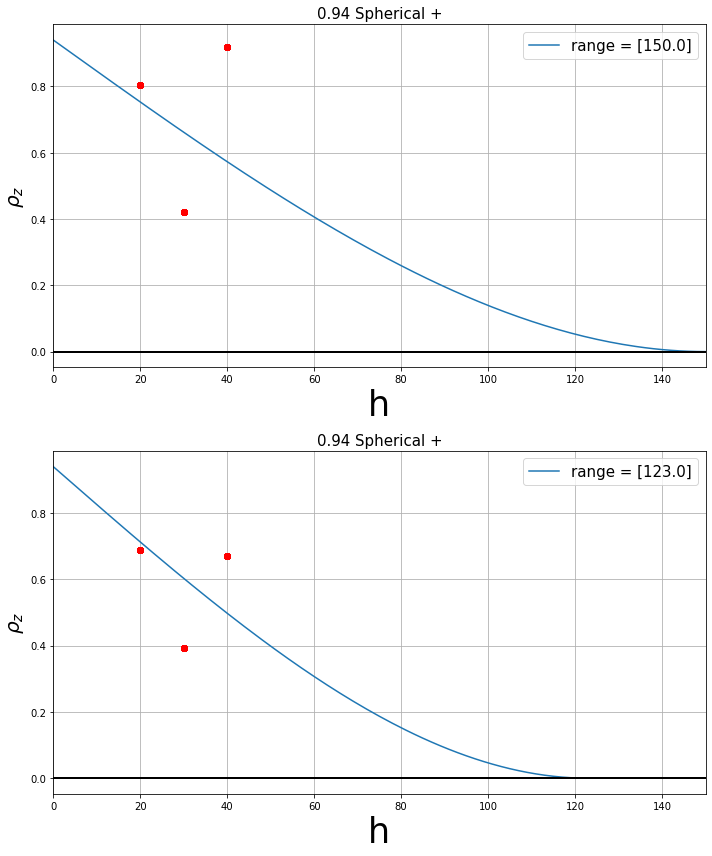

In [389]:
varg_type = 2  # See Correlogram Functions
k = 0 # Permet de changer de direction
nstruct = dict_primary["nstruct"]
MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien"}

label_dict = {0: dict_primary["a_max"],
             1 : dict_primary["a_min"]}

# Title name
TITLE = ""
count = 1
for cc,vtype in zip(dict_primary["cc"],dict_primary["vtype"]) :
    model = MODEL_name[vtype]
    if count == 1 :
        TITLE += f"{cc} {model} +" 
    elif count == len(dict_primary["cc"]):
        TITLE += f" {cc} {model} "
    elif count == 1 & len(dict_primary["cc"]) == 1 :
        TITLE += f"{cc} {model}"                    
    else : 
        TITLE += f" {cc} {model} +"
    count += 1

fig, axes = plt.subplots(2,1, figsize=(10, 12))
cz_True = np.zeros(shape=(LENGTH + 1))
for s in range(2) :
    for h in range(0, LENGTH + 1):
        # Calcul Correlogram model Z
        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type, dict_primary,nstruct)
        H[h] = h
        MM_vargs = [ cz_True,cy,czy ]

        # Label Display 
    for i in [0]:
        LABEL =  "range = {}".format(label_dict[s])
        axes[s].plot(H, MM_vargs[i], label=LABEL)
        var = locals()["varc_{}".format(i + 1)]

        # Calcul des valeurs de Correlogram à partir du variogram
    for h in range(1, LENGTH):
        H[h] = h
        axes[s].plot(
            var["Lag Distance"][var["Variogram Index"] == (s + 1)],
            Sill_vals[i]
            - var["Variogram Value"][var["Variogram Index"] == (s + 1)],
            "o",
            color=colors[i],
        )
        axes[s].set_ylabel(labels_2[i], size=20)
        axes[s].plot(H, ones, color="Black")
        axes[s].set_xlabel("h", size=35)
        axes[s].set_title(TITLE, size=15)
        axes[s].legend(loc="best", prop={"size": 15})
        axes[s].grid()
    plt.setp(axes, xlim=(0, LENGTH))
    plt.tight_layout()

# Ici pas de direction précise, à inclure dans une loop le cas échéant
    varg_type = varg_type + 1
    k +=1

## Secondary

In [390]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Y_alternate(h1, h2, k,dict_C_Y,nstruct = 1,Azimuth = 0):
    C = []
    vtype = dict_C_Y["vtype"]
    a_max = dict_C_Y["a_max"]
    a_min = dict_C_Y["a_min"] 
    cc = dict_C_Y["cc"]
    #Azimuth = 45
    c = 0.0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                )
            ).sum(axis=1)
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1)  * cc[i]

    return c

In [391]:
def optimize_RMSE_Y_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] à la Sill_value
    gamma= b*spherical(a_min,a_max)
    pour un modèle à plusieur couche => inserer en tant que list : a_max = [a_max1,a_max2]
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    var = var.dropna(axis = 0)
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    if len(x0) == 3 :
        a_max_y_0 = [x[0]]         # range
        a_min_y_0 = [x[1]]
        cc_y_0 = [x[2]]            # effet pépite
        MODEL_value = [args[2]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_y_0 = x[0::3]        # range
        a_min_y_0 = x[1::3]
        cc_y_0 = x[2::3]           # effet pépite
        MODEL_value = args[2::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_secondary_0 = {"a_max" : a_max_y_0
                ,"a_min" : a_min_y_0
                ,"cc" : cc_y_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_secondary_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_Y_alternate(np.matrix(h), np.matrix(h), k, dict_secondary_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [392]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_y_0 = np.array([50])
a_min_y_0 = np.array([72])
cc_y_0    = np.array([0.5])
MODEL_value = np.array([MODEL_type["Spherical"]])


var, Sill_value,= varc_2, Sill_vals[0] # variogram , Variance
nstruct = len(a_max_y_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_y_0[i]
    b = a_min_y_0[i]
    c = cc_y_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150],[0,5]]
if nstruct > 1 :
    Bounds *=  len(a_max_y_0)


Y_model = minimize(optimize_RMSE_Y_model,x0,args = args,
                            method='TNC', jac = '3-point',# Minimize
                            bounds = Bounds,tol = 1e-9)


print(Y_model)

a_max_y = [float("{:.0f}".format(x)) for x in Y_model.x[0::3]]
a_min_y = [float("{:.0f}".format(x)) for x in Y_model.x[1::3]]
cc_y = [float("{:.2f}".format(x)) for x in Y_model.x[2::3]]

dict_secondary = {"a_max" : a_max_y
                ,"a_min" : a_min_y
                ,"cc" : cc_y
                ,"vtype" : MODEL_value
                  ,"nstruct" : nstruct
}

{'a_max': [50.0], 'a_min': [72.0], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17641941455796656, 0.1577411921233429] 

{'a_max': [49.99969722727738], 'a_min': [72.0], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17642065819020797, 0.1577411921233429] 

{'a_max': [50.00030277272262], 'a_min': [72.0], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17641817093329182, 0.1577411921233429] 

{'a_max': [50.0], 'a_min': [71.99956400727943], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17641941455796656, 0.1577424540037708] 

{'a_max': [50.0], 'a_min': [72.00043599272057], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17641941455796656, 0.15773993025501504] 

{'a_max': [50.0], 'a_min': [72.0], 'cc': [0.49999394454554763], 'vtype': [1]}
RMSE : [0.17642151673353088, 0.1577440440185249] 

{'a_max': [50.0], 'a_min': [72.0], 'cc': [0.5000060554544524], 'vtype': [1]}
RMSE : [0.17641731240216987, 0.15773834025135408] 

{'a_max': [50.00000197452886], 'a_min': [72.0000013913182], 'cc': [0.5000004369790831], 'vtype': [1]}
RMSE : [0.176419254749

{'a_max': [61.64831783834229], 'a_min': [80.32325693281], 'cc': [0.7602861000819922], 'vtype': [1]}
RMSE : [0.0742285453788035, 0.07484652323210919] 

{'a_max': [61.648318166128895], 'a_min': [80.3232572315871], 'cc': [0.760280041542746], 'vtype': [1]}
RMSE : [0.07422764821070928, 0.0748447361049603] 

{'a_max': [61.64794485754617], 'a_min': [80.3232572315871], 'cc': [0.760280041542746], 'vtype': [1]}
RMSE : [0.07422827894097604, 0.0748447361049603] 

{'a_max': [61.64869147471162], 'a_min': [80.3232572315871], 'cc': [0.760280041542746], 'vtype': [1]}
RMSE : [0.07422701753925136, 0.0748447361049603] 

{'a_max': [61.648318166128895], 'a_min': [80.32277083776147], 'cc': [0.760280041542746], 'vtype': [1]}
RMSE : [0.07422764821070928, 0.07484514543472798] 

{'a_max': [61.648318166128895], 'a_min': [80.32374362541275], 'cc': [0.760280041542746], 'vtype': [1]}
RMSE : [0.07422764821070928, 0.0748443268261119] 

{'a_max': [61.648318166128895], 'a_min': [80.3232572315871], 'cc': [0.7602739860882

RMSE : [0.057992015291877835, 0.0341299153856238] 

{'a_max': [76.5251527727177], 'a_min': [105.64491004582926], 'cc': [0.6313965625985265], 'vtype': [1]}
RMSE : [0.05799197867103721, 0.03412992885524435] 

{'a_max': [76.5251527727177], 'a_min': [105.64618950945881], 'cc': [0.6313965625985265], 'vtype': [1]}
RMSE : [0.05799197867103721, 0.03412990197193976] 

{'a_max': [76.5251527727177], 'a_min': [105.64554977764404], 'cc': [0.6313905071440741], 'vtype': [1]}
RMSE : [0.0579925147527985, 0.03412934690782484] 

{'a_max': [76.5251527727177], 'a_min': [105.64554977764404], 'cc': [0.6314026180529789], 'vtype': [1]}
RMSE : [0.05799144280070695, 0.03413048434564182] 

{'a_max': [76.52515150074066], 'a_min': [105.64555011606114], 'cc': [0.6313964658320321], 'vtype': [1]}
RMSE : [0.05799198713554153, 0.03412990629041429] 

{'a_max': [76.52468810617128], 'a_min': [105.64555011606114], 'cc': [0.6313964658320321], 'vtype': [1]}
RMSE : [0.05799195056579727, 0.03412990629041429] 

{'a_max': [76.525

RMSE : [0.058000519151544624, 0.0341061870772871] 

{'a_max': [76.21349594305241], 'a_min': [105.85180547090555], 'cc': [0.631171333026606], 'vtype': [1]}
RMSE : [0.05800051943977864, 0.0341061870772871] 

{'a_max': [76.2130344384937], 'a_min': [105.85116449011882], 'cc': [0.631171333026606], 'vtype': [1]}
RMSE : [0.05800051927049149, 0.03410618716198177] 

{'a_max': [76.2130344384937], 'a_min': [105.85244645169227], 'cc': [0.631171333026606], 'vtype': [1]}
RMSE : [0.05800051927049149, 0.034106187048241185] 

{'a_max': [76.2130344384937], 'a_min': [105.85180547090555], 'cc': [0.6311652775721536], 'vtype': [1]}
RMSE : [0.05800110966141821, 0.03410559694114082] 

{'a_max': [76.2130344384937], 'a_min': [105.85180547090555], 'cc': [0.6311773884810584], 'vtype': [1]}
RMSE : [0.05799992908902297, 0.03410677769601157] 

{'a_max': [76.21208140107011], 'a_min': [105.85231023745838], 'cc': [0.6311711447645747], 'vtype': [1]}
RMSE : [0.05800053743651321, 0.0341061686923465] 

{'a_max': [76.211619

In [393]:
dict_secondary

{'a_max': [76.0],
 'a_min': [106.0],
 'cc': [0.63],
 'vtype': array([1]),
 'nstruct': 1}

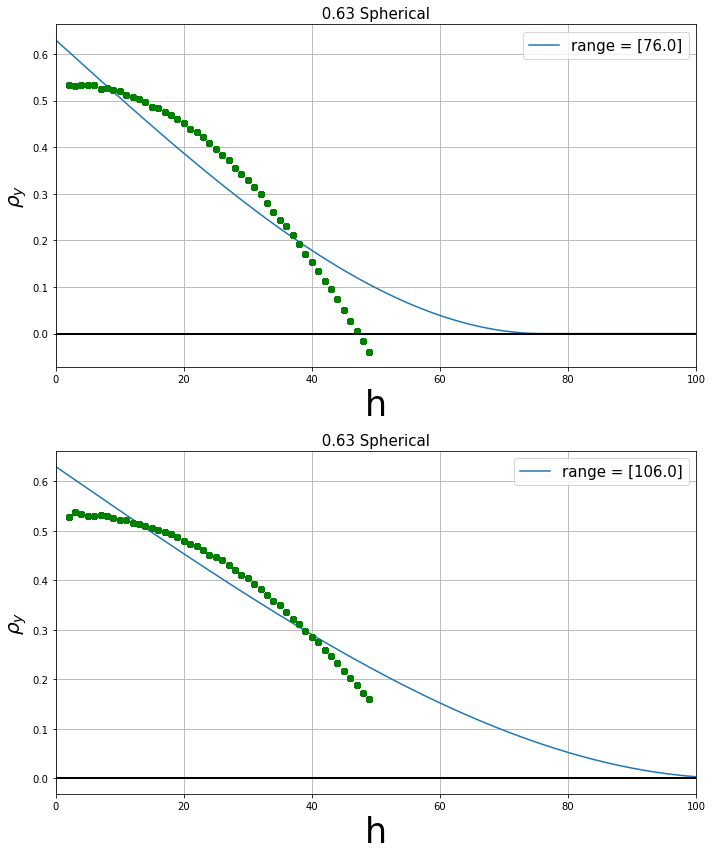

In [394]:
varg_type = 2  # See Correlogram Functions
k = 0 # Permet de changer de direction
nstruct = 1

MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien"}

label_dict = {0: dict_secondary["a_max"],
             1 : dict_secondary["a_min"]}

fig, axes = plt.subplots(2,1, figsize=(10, 12))
cy = np.zeros(shape=(LENGTH + 1))

# Title name
TITLE = ""
count = 1
for cc,vtype in zip(dict_secondary["cc"],dict_secondary["vtype"]) :
    model = MODEL_name[vtype]
    if count == 1 & len(dict_secondary["cc"]) >= 2 :
        TITLE += f"{cc} {model} +" 
    elif count == len(dict_secondary["cc"]):
        TITLE += f" {cc} {model} "
    elif count == 1 & len(dict_secondary["cc"]) == 1 :
        TITLE += f"{cc} {model}"                    
    else : 
        TITLE += f" {cc} {model} +"
    count += 1

for s in range(2) :
    for h in range(0, LENGTH + 1):
        # Calcul Correlogram model Z
        cy[h] = C_Y_alternate(np.matrix(h), np.matrix(h),varg_type, dict_secondary,nstruct)
        H[h] = h
        MM_vargs = [ cz_True,cy,czy ]

        # Label Display 
    for i in [1]:
        LABEL =  "range = {}".format(label_dict[s])
        axes[s].plot(H, MM_vargs[i], label=LABEL)
        var = locals()["varc_{}".format(i + 1)]

        # Calcul des valeurs de Correlogram à partir du variogram
    for h in range(1, LENGTH):
        H[h] = h
        axes[s].plot(
            var["Lag Distance"][var["Variogram Index"] == (s + 1)],
            Sill_vals[i]
            - var["Variogram Value"][var["Variogram Index"] == (s + 1)],
            "o",
            color=colors[i],
        )
        axes[s].set_ylabel(labels_2[i], size=20)
        axes[s].plot(H, ones, color="Black")
        axes[s].set_xlabel("h", size=35)
        axes[s].set_title(TITLE, size=15)
        axes[s].legend(loc="best", prop={"size": 15})
        axes[s].grid()
    plt.setp(axes, xlim=(0, 100))
    plt.tight_layout()

# Ici pas de direction précise, à inclure dans une loop le cas échéant
    varg_type = varg_type + 1
    k +=1

## Cross

In [395]:
def C_ZY(h1, h2, k,dict_C_ZY,nstruct = 1,Azimuth = 0):
    C = []
    vtype = dict_C_ZY["vtype"]
    a_max = dict_C_ZY["a_max"]
    a_min = dict_C_ZY["a_min"] 
    cc = dict_C_ZY["cc"]
    #Azimuth = 45
    c = 0
    for i in range(nstruct):
        
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

In [396]:
def optimize_RMSE_ZY_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] à la Sill_value
    gamma= b*spherical(a_min,a_max)
    pour un modèle à plusieur couche => inserer en tant que list : a_max = [a_max1,a_max2]
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    if len(x0) == 3 :
        a_max_zy_0 = [x[0]]         # range
        a_min_zy_0 = [x[1]]
        cc_zy_0 = [args[2]]         # effet pépite
        MODEL_value = [args[3]]     # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_zy_0 = x[0::3]        # range
        a_min_zy_0 = x[1::3]
        cc_zy_0 = [args[2]]         # effet pépite
        MODEL_value = args[3::]     # type de modèle
        nstruct = len(MODEL_value)  # nombre de couche
    
    dict_cross_0 = {"a_max" : a_max_zy_0
                ,"a_min" : a_min_zy_0
                ,"cc" : cc_zy_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_cross_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_ZY(np.matrix(h), np.matrix(h), k, dict_cross_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [397]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

corr = np.corrcoef(Primary["Primary"], Primary["Secondary"])[0,1]
corr = float("{:.2f}".format(corr))
print("Coeff de correlation :", corr)

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_zy_0  = np.array([30])
a_min_zy_0  = np.array([30])
cc_zy_0     = [corr]
MODEL_value = np.array([MODEL_type["Spherical"]])


var, Sill_value,= varc_3, corr # variogram , Variance
nstruct = len(a_max_zy_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_zy_0[i]
    b = a_min_zy_0[i]
    c = cc_zy_0[i] # cc n'est pas à minimiser ici 
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b])
    args = np.append(args,[c,d])
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150]]
if nstruct > 1 :
    Bounds *=  len(a_max_zy_0)


# Minimize
ZY_model = minimize(optimize_RMSE_ZY_model,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(ZY_model)

a_max_zy = [float("{:.0f}".format(x)) for x in ZY_model.x[0::3]]
a_min_zy = [float("{:.0f}".format(x)) for x in ZY_model.x[1::3]]
cc_zy = [corr]

dict_cross = {"a_max" : a_max_zy
                ,"a_min" : a_min_zy
                ,"cc" : cc_zy
                ,"vtype" : MODEL_value
              ,"nstruct"  : nstruct
}

Coeff de correlation : 0.24
{'a_max': array([30.]), 'a_min': array([30.]), 'cc': [0.24], 'vtype': array([1.0], dtype=object)}
RMSE : [2.3389625654309967, 2.457203351117981] 

{'a_max': array([29.99981834]), 'a_min': array([30.]), 'cc': [0.24], 'vtype': array([1.0], dtype=object)}
RMSE : [2.3389621909821203, 2.457203351117981] 

{'a_max': array([30.00018166]), 'a_min': array([30.]), 'cc': [0.24], 'vtype': array([1.0], dtype=object)}
RMSE : [2.3389629398787353, 2.457203351117981] 

{'a_max': array([30.]), 'a_min': array([29.99981834]), 'cc': [0.24], 'vtype': array([1.0], dtype=object)}
RMSE : [2.3389625654309967, 2.457202920820902] 

{'a_max': array([30.]), 'a_min': array([30.00018166]), 'cc': [0.24], 'vtype': array([1.0], dtype=object)}
RMSE : [2.3389625654309967, 2.4572037814144925] 

{'a_max': array([29.99999902]), 'a_min': array([29.99999887]), 'cc': [0.24], 'vtype': array([1.0], dtype=object)}
RMSE : [2.338962563402188, 2.457203348438855] 

{'a_max': array([29.99981735]), 'a_min': a

<ipython-input-395-cd0a2b68ef86>:36: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_min[i]
<ipython-input-395-cd0a2b68ef86>:36: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_min[i]
<ipython-input-395-cd0a2b68ef86>:36: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_min[i]


In [398]:
dict_cross

{'a_max': [4.0],
 'a_min': [0.0],
 'cc': [0.24],
 'vtype': array([1]),
 'nstruct': 1}

<ipython-input-395-cd0a2b68ef86>:36: RuntimeWarning: invalid value encountered in true_divide
  d = Q1 / a_min[i]
<ipython-input-382-832989bc7701>:5: RuntimeWarning: invalid value encountered in greater
  c[h > 1] = 0
<ipython-input-395-cd0a2b68ef86>:36: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_min[i]


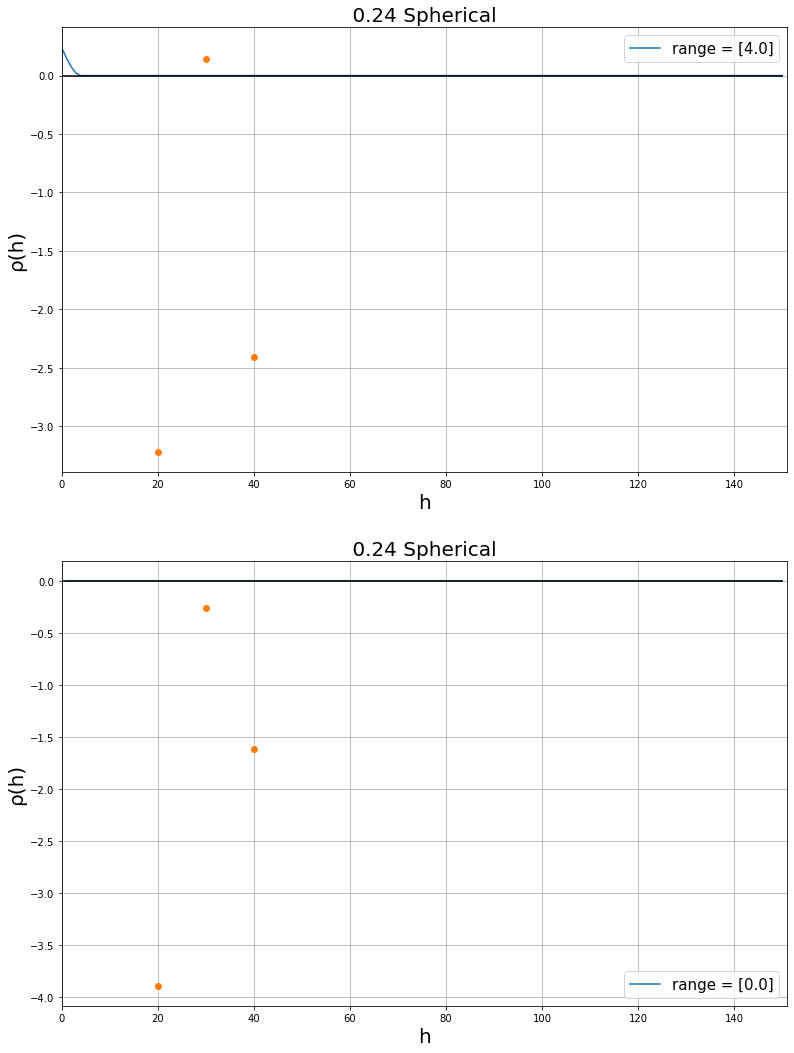

In [399]:
## Constantes de démarrage
varg_type = 2  # See Correlogram Functions
MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien"}

label_dict = {0: dict_cross["a_max"],
             1 : dict_cross["a_min"]}

fig, axes = plt.subplots(2, 1, figsize=(13, 18))
czy = np.zeros(shape=(LENGTH + 1))

# Title name
TITLE = ""
count = 1
for cc,vtype in zip(dict_cross["cc"],dict_cross["vtype"]) :
    model = MODEL_name[vtype]
    if count == 1 & len(dict_cross["cc"]) >= 2 :
        TITLE += f"{cc} {model} +" 
    elif count == len(dict_cross["cc"]):
        TITLE += f" {cc} {model} "
    elif count == 1 & len(dict_cross["cc"]) == 1 :
        TITLE += f"{cc} {model}"                    
    else : 
        TITLE += f" {cc} {model} +"
    count += 1


for s in range(2) :

    for h in range(0, LENGTH + 1):
        czy[h]= C_ZY(np.matrix(h), np.matrix(h),varg_type,dict_cross, 1)
        H[h] = h
    MM_vargs = [ cz_True,cy,czy ]

    for i in [2]: 
        LABEL =  "range = {}".format(label_dict[s])
        axes[s].plot(H, MM_vargs[i], label=LABEL)

        if (i + 1) <= 3:
            var = locals()["varc_{}".format(i + 1)]
            axes[s].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (s + 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (s + 1)
                ],
                "o"
                )

    axes[s].plot(H, ones, color="Black")
    axes[s].grid()
    axes[s].set_xlim(0, LENGTH + 1)
    #axes[k].set_ylim(-0.1, 1)
    axes[s].set_ylabel("\u03C1(h)", size=20)
    axes[s].set_xlabel("h", size=20)
    axes[s].set_title(TITLE,size=20)
    axes[s].legend(loc="best", prop={"size": 15})
    varg_type = varg_type + 1

    
Save = False 
if Save :
    fileout =  "C:/Users/Alexandre/Desktop/Cours/Stage/\collocatedcokriging/Correlogram_test/"+Model+".png"
    plt.tight_layout()
    plt.savefig('fileout', bbox_inches="tight", dpi=300)
    

# Correlogram MM2 

### Scalling Correlogram 

In [400]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_r (h1, h2, k, dict_C_r,nstruct = 1,Azimuth = 0 ):
    C = []
    vtype = dict_C_r["vtype"]
    a_max = dict_C_r["a_max"]
    a_min = dict_C_r["a_min"] 
    cc = dict_C_r["cc"]
    #Azimuth = 45
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

### C_Z_MM2

In [401]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# Corr = correlation between primary and secondary data
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_MM2(h1, h2, k, corr,dict_secondary, dict_C_r ):
    
    return (C_Y_alternate(h1, h2, k,dict_secondary, nstruct = 1) * corr ** 2) + (
        (1 - corr ** 2) * C_r (h1, h2, k,dict_C_r,nstruct = 1 )
    )

In [402]:
def optimize_RMSE_scalling_correlogram(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] correspond à la Sill_value (= 1)
    gamma= b*second(a_min,a_max)+ c*first(a_min_g,a_max_g)
    On minimize ici la différence entre le correlogram généré C_Z_MII ( qui se base sur le correlogram Y) et
    le modèle de correlogram ce C_Z. Les modifications s'effectuent sur le correlogram C_r 
    """
    
    dict_secondary = args[0] # dictionnaire des valeurs du correlogram secondaire
    dict_primary   = args[1] # dictionnaire des valeurs du correlogram primaire
    corr  = args[2]
    RMSE = [] # Liste des RMSE
    
    Direction = ["Major", "Minor"] #Deux directions à additionner
    
    ## x0
    if len(x0) == 3 :
        a_max_r_0 = [x[0]]         # range
        a_min_r_0 = [x[1]]
        cc_r_0 = [x[2]]            # effet pépite
        MODEL_value = [args[3]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches", mais n'est pas forcément compatible.
        
        a_max_r_0 = x[0::3]        # range
        a_min_r_0 = x[1::3]
        cc_r_0 = x[2::3]           # effet pépite
        MODEL_value = args[3::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_scalling_0 = {"a_max" : a_max_r_0
                ,"a_min" : a_min_r_0
                ,"cc" : cc_r_0
                ,"vtype" : MODEL_value
                 }
    print(dict_scalling_0)
    for i,Dir in enumerate(Direction) :
        
        # Inititialisation des matrices
        cy = np.zeros(shape=(101))
        cr = np.zeros(shape=(101))
        cz_mm2 = np.zeros(shape=(101))
        cz = np.zeros(shape=(101))
        k = i + 2                # numéro de la direction 
        
        for h in range(0, 101):
            cy[h] = C_Y_alternate(np.matrix(h), np.matrix(h), k,
                                  dict_secondary, nstruct = 1)

            cz[h] = C_Z_alternate(np.matrix(h), np.matrix(h),k,
                                  dict_primary, nstruct = 1)

            cr[h] = C_r(np.matrix(h), np.matrix(h), k,
                        dict_scalling_0,nstruct = 1 )

            cz_mm2[h] = C_Z_MM2(np.matrix(h), np.matrix(h), k, corr,dict_secondary, dict_scalling_0)

            RMSE.append(np.sqrt(mean_squared_error(cz,cz_mm2))) 
    return sum(RMSE)

In [403]:
print('-' * 30)
print("dict_primary :", dict_primary)
print("dict_secondary :", dict_secondary)
print("dict_cross :", dict_cross)

------------------------------
dict_primary : {'a_max': [150.0], 'a_min': [123.0], 'cc': [0.94], 'vtype': array([1]), 'nstruct': 1}
dict_secondary : {'a_max': [76.0], 'a_min': [106.0], 'cc': [0.63], 'vtype': array([1]), 'nstruct': 1}
dict_cross : {'a_max': [4.0], 'a_min': [0.0], 'cc': [0.24], 'vtype': array([1]), 'nstruct': 1}


In [404]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])

# range max, min, effet pepite, type de couche
a_max_r_0 = np.array([10])
a_min_r_0 = np.array([10])
cc_r_0    = np.array([2])
MODEL_value = np.array([MODEL_type["Spherical"]])
nstruct = len(a_max_r_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
args = np.append(args,[dict_secondary,dict_primary,corr])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_r_0[i]
    b = a_min_r_0[i]
    c = cc_r_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150],[0,5]]
if nstruct > 1 :
    Bounds *=  nstruct


# Minimize
scalling_model = minimize(optimize_RMSE_scalling_correlogram,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(scalling_model)

a_max_r = [float("{:.0f}".format(x)) for x in scalling_model.x[0::3]]
a_min_r = [float("{:.0f}".format(x)) for x in scalling_model.x[1::3]]
cc_r = [float("{:.2f}".format(x)) for x in scalling_model.x[2::3]]

dict_scalling = {"a_max" : a_max_r
                ,"a_min" : a_min_r
                ,"cc" : cc_r
                ,"vtype" : MODEL_value
}

{'a_max': [10.0], 'a_min': [10.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [9.999939445455476], 'a_min': [10.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [10.000060554544524], 'a_min': [10.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [10.0], 'a_min': [9.999939445455476], 'cc': [2.0], 'vtype': [1]}
{'a_max': [10.0], 'a_min': [10.000060554544524], 'cc': [2.0], 'vtype': [1]}
{'a_max': [10.0], 'a_min': [10.0], 'cc': [1.9999878890910952], 'vtype': [1]}
{'a_max': [10.0], 'a_min': [10.0], 'cc': [2.0000121109089046], 'vtype': [1]}
{'a_max': [10.000002235510536], 'a_min': [10.000002284017711], 'cc': [1.9999999431146835], 'vtype': [1]}
{'a_max': [9.999941680952475], 'a_min': [10.000002284017711], 'cc': [1.9999999431146835], 'vtype': [1]}
{'a_max': [10.000062790068597], 'a_min': [10.000002284017711], 'cc': [1.9999999431146835], 'vtype': [1]}
{'a_max': [10.000002235510536], 'a_min': [9.999941729459357], 'cc': [1.9999999431146835], 'vtype': [1]}
{'a_max': [10.000002235510536], 'a_min': [10.000062838576065], '

{'a_max': [120.84657918028353], 'a_min': [118.02690502819661], 'cc': [0.965578025888455], 'vtype': [1]}
{'a_max': [120.84584739932757], 'a_min': [118.02690502819661], 'cc': [0.965578025888455], 'vtype': [1]}
{'a_max': [120.84731096123949], 'a_min': [118.02690502819661], 'cc': [0.965578025888455], 'vtype': [1]}
{'a_max': [120.84657918028353], 'a_min': [118.02619032164905], 'cc': [0.965578025888455], 'vtype': [1]}
{'a_max': [120.84657918028353], 'a_min': [118.02761973474416], 'cc': [0.965578025888455], 'vtype': [1]}
{'a_max': [120.84657918028353], 'a_min': [118.02690502819661], 'cc': [0.9655719704340026], 'vtype': [1]}
{'a_max': [120.84657918028353], 'a_min': [118.02690502819661], 'cc': [0.9655840813429074], 'vtype': [1]}
{'a_max': [120.84663493993479], 'a_min': [118.02694396762041], 'cc': [0.9655779696720193], 'vtype': [1]}
{'a_max': [120.84590315864118], 'a_min': [118.02694396762041], 'cc': [0.9655779696720193], 'vtype': [1]}
{'a_max': [120.8473667212284], 'a_min': [118.02694396762041]

{'a_max': [150.0], 'a_min': [131.2419297726284], 'cc': [0.9615781348804258], 'vtype': [1]}
{'a_max': [149.99909168183214], 'a_min': [131.2419297726284], 'cc': [0.9615781348804258], 'vtype': [1]}
{'a_max': [149.99818336366428], 'a_min': [131.2419297726284], 'cc': [0.9615781348804258], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [131.2411350431004], 'cc': [0.9615781348804258], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [131.2427245021564], 'cc': [0.9615781348804258], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [131.2419297726284], 'cc': [0.9615720794259733], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [131.2419297726284], 'cc': [0.9615841903348782], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [107.34136611883065], 'cc': [0.9708113891274843], 'vtype': [1]}
{'a_max': [149.99909168183214], 'a_min': [107.34136611883065], 'cc': [0.9708113891274843], 'vtype': [1]}
{'a_max': [149.99818336366428], 'a_min': [107.34136611883065], 'cc': [0.9708113891274843], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [107.34

{'a_max': [149.99818336366428], 'a_min': [123.76943678190929], 'cc': [0.9601616603914351], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [123.76868730172227], 'cc': [0.9601616603914351], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [123.77018626209632], 'cc': [0.9601616603914351], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [123.76943678190929], 'cc': [0.9601556049369827], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [123.76943678190929], 'cc': [0.9601677158458876], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [123.59814951188525], 'cc': [0.9607167855501522], 'vtype': [1]}
{'a_max': [149.99909168183214], 'a_min': [123.59814951188525], 'cc': [0.9607167855501522], 'vtype': [1]}
{'a_max': [149.99818336366428], 'a_min': [123.59814951188525], 'cc': [0.9607167855501522], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [123.59740106892049], 'cc': [0.9607167855501522], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [123.59889795485002], 'cc': [0.9607167855501522], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [123.59814951

{'a_max': [150.0], 'a_min': [123.64593433389305], 'cc': [0.959689516556624], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [123.64593433389305], 'cc': [0.9597016274655289], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [123.64593433384641], 'cc': [0.9596955720113272], 'vtype': [1]}
{'a_max': [149.99909168183214], 'a_min': [123.64593433384641], 'cc': [0.9596955720113272], 'vtype': [1]}
{'a_max': [149.99818336366428], 'a_min': [123.64593433384641], 'cc': [0.9596955720113272], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [123.64518560152283], 'cc': [0.9596955720113272], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [123.64668306617], 'cc': [0.9596955720113272], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [123.64593433384641], 'cc': [0.9596895165568747], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [123.64593433384641], 'cc': [0.9597016274657796], 'vtype': [1]}
{'a_max': [150.0], 'a_min': [123.63894241923364], 'cc': [0.9597331357806382], 'vtype': [1]}
{'a_max': [149.99909168183214], 'a_min': [123.638942419233

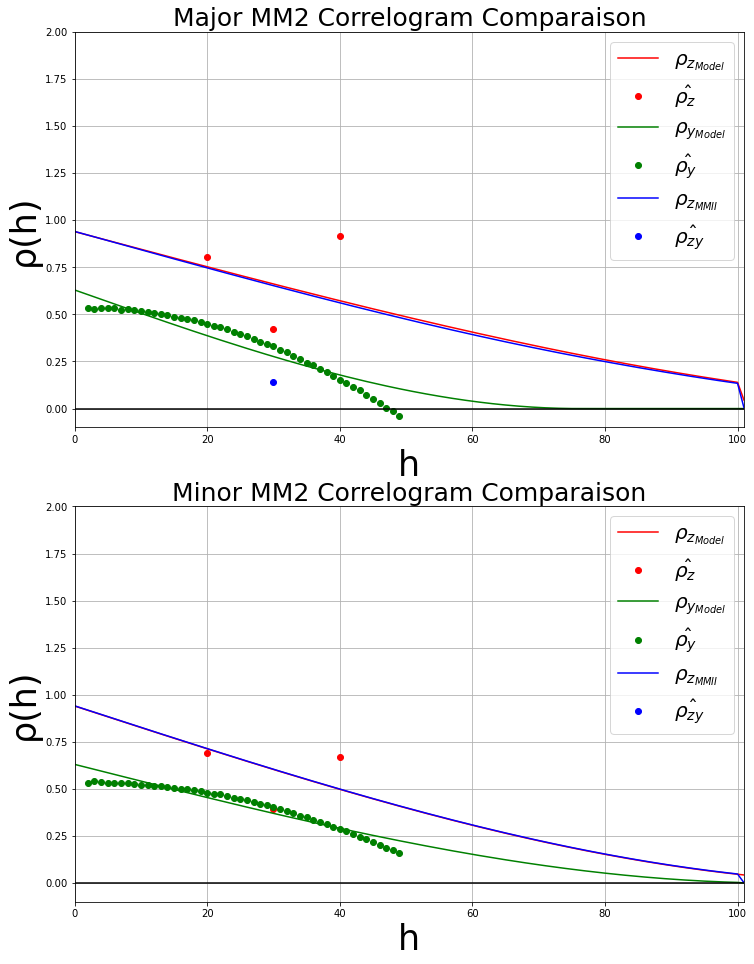

In [405]:
labels_MM = ['$ρ_{z_{Model}}$', '$ρ_{y_{Model}}$', '$ρ_{z_{MMII}}$']
varg_type = 2  # See Correlogram Functions
k = 0
cy = np.zeros(shape=(LENGTH + 1))
cz = np.zeros(shape=(LENGTH + 1))
cr = np.zeros(shape=(LENGTH + 1))
cz_mm2 = np.zeros(shape=(LENGTH + 1))

fig, axes = plt.subplots(2, 1, figsize=(12, 16))
for s,Dir in enumerate(["Major","Minor"]):
    for h in range(0, 101):

        cy[h]= C_Y_alternate(np.matrix(h), np.matrix(h), varg_type,dict_secondary, nstruct = 1)

        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type,dict_primary, nstruct = 1)

        cz[h] = C_Z_MM2(np.matrix(h), np.matrix(h), varg_type, corr,dict_secondary,dict_scalling )

        cr[h] = C_r (np.matrix(h), np.matrix(h), varg_type, dict_scalling,nstruct = 1 )

        H[h] = h
    MM_vargs = [cz_True, cy, cz]
    
    for i in range(0, 3):
        axes[s].plot(H, MM_vargs[i], color=colors[i], label=labels_MM[i])
        if (i + 1) < 4:
            var = locals()["varc_{}".format(i + 1)]
            axes[s].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "o",
                color=colors[i],
                label=labels_1[i],
            )

    axes[s].plot(H, ones, color="Black")
    axes[s].grid()
    axes[s].set_xlim(0, 101)
    axes[s].set_ylim(-0.1, 2)
    axes[s].set_ylabel("\u03C1(h)", size=35)
    axes[s].set_xlabel("h", size=35)
    axes[s].set_title(
        Dir+" MM2 Correlogram Comparaison",
        size=25,
    )
    axes[s].legend(loc="best", prop={"size": 20})
    varg_type = varg_type + 1
    k += 1

# LMC 

In [406]:
def optimize_RMSE_LMC_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] correspond à la Sill_value (= 1)
    gamma= b*second(a_min,a_max)+ c*first(a_min_g,a_max_g)
    On cherche à minimiser un seul modèle qui serait compatible avec les trois autres correlogrammes (pas les modèles) 
    """
    
    df_primary   = args[0] # DataFrame des valeurs primaire
    df_secondary = args[1] # DataFrame des valeurs secondaire
    df_cross     = args[2] # DataFrame des valeurs cross 
    sill_value_z = args[3]
    sill_value_y = args[4]
    corr         = args[5]
    nstruct      = args[-1]
    RMSE = [] # Liste des RMSE
    Direction = ["Major", "Minor"] #Deux directions 
    ## x0
    if nstruct == 1 : # modèle à une couche
        a_max_0 = [x[0]]         # range
        a_min_0 = [x[1]]
        cc_0 = x[2::]            # effet pépite
        MODEL_value = [args[6]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches", mais n'est pas forcément compatible avec les données.
    
        a_max_0 = x[0:-3*nstruct:nstruct]     # range
        a_min_0 = x[1:-3*nstruct:nstruct]
        cc_0 = x[nstruct*nstruct::]   # effet pépite
        MODEL_value = args[6:6+nstruct]      # type de modèle
        
        ## Condition des sills, il faut c1 + c2 + .. = sill_value du correlogram
        for i,sill in zip([0,1,2],[sill_value_z,sill_value_y,corr]) :
            for c1,c2 in [cc_0[i::3]] :
                if c1 + c2 > sill :
                    cc_0[i+3] = sill - cc_0[i]
                    print(cc_0[i],cc_0[i+3])

    dict_model_LMC_z = {"a_max" : a_max_0
                ,"a_min" : a_min_0
                ,"cc" : cc_0[0::3]
                ,"vtype" : MODEL_value
                 }
    
    dict_model_LMC_y = {"a_max" : a_max_0
                ,"a_min" : a_min_0
                ,"cc" : cc_0[1::3]
                ,"vtype" : MODEL_value
                 }
    
    dict_model_LMC_zy = {"a_max" : a_max_0
                ,"a_min" : a_min_0
                ,"cc" : cc_0[2::3]
                ,"vtype" : MODEL_value
                 }
    
    print("Z : ",dict_model_LMC_z,'\n Y :',dict_model_LMC_y,'\n ZY :',dict_model_LMC_zy)
    for i,Dir in enumerate(Direction) :
        k = i + 2
        MODEL_y  = []
        MODEL_z  = []
        MODEL_zy = []
        
        ### Correlogramme Y
        lag_value_y = df_secondary["Lag Distance"][df_secondary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value_y = sill_value_y - df_secondary["Variogram Value"][df_secondary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        
        for h in lag_value_y:
            MODEL = C_Y_alternate(np.matrix(h), np.matrix(h), k,
                                  dict_model_LMC_y,nstruct)
            MODEL_y.append(MODEL.tolist()[0][0])
        RMSE.append(np.sqrt(mean_squared_error(variogram_value_y,MODEL_y)))
        
        ### Correlogramme Z
        lag_value_z = df_primary["Lag Distance"][df_primary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value_z = sill_value_z - df_primary["Variogram Value"][df_primary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        for h in lag_value_z:
            MODEL = C_Z_alternate(np.matrix(h), np.matrix(h), k,
                                  dict_model_LMC_z,nstruct)
            MODEL_z.append(MODEL.tolist()[0][0])
        RMSE.append(np.sqrt(mean_squared_error(variogram_value_z,MODEL_z)))
        
        ## Correlogramme ZY
        lag_value_zy = df_cross["Lag Distance"][df_cross["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value_zy = corr - df_cross["Variogram Value"][df_cross["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        for h in lag_value_zy:
            MODEL = C_ZY(np.matrix(h), np.matrix(h), k,
                                  dict_model_LMC_zy,nstruct)
            
            MODEL_zy.append(MODEL.tolist()[0][0])
        RMSE.append(np.sqrt(mean_squared_error(variogram_value_zy,MODEL_zy)))
    #print("RMSE value :",RMSE , " sum(RMSE) :",sum(RMSE),
    print("\n", "-" * 45)
    return sum(RMSE)

In [409]:
x0

array([40. , 40. , 70. , 70. ,  0.6,  0.4,  0.3,  0.2,  0.5,  0.2])

In [ ]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])

# range max, min, effet pepite, type de couche
a_max_LMC_0  = np.array([40,70])
a_min_LMC_0  = np.array([40,70])
cc_LMC_0     = np.array([0.6,0.4,0.3,0.2,0.5,0.2]) # les cc sont en fin de liste
sill_value_z = Sill_vals[0]
sill_value_y = Sill_vals[1]
sill_value_zy = Sill_vals[2]

MODEL_value = np.array([MODEL_type["Spherical"],MODEL_type["Gaussien"]]  )
nstruct = len(a_max_LMC_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
args = np.append(args,[varc_1,varc_2,varc_3,sill_value_z,sill_value_y,sill_value_zy])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_LMC_0[i]
    b = a_min_LMC_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b])
    args = np.append(args,[d])
args = np.append(args,nstruct)
c = cc_LMC_0.tolist()
x0 = np.append(x0,c)
x0 = np.delete(x0,0)
args = np.delete(args,0)


# Boundaries 
Bounds = [[0,100],[0,100]] * nstruct
Bounds +=  [[0,1],[0,1],[0,corr]] * nstruct
      
# Minimize
LMC_model = minimize(optimize_RMSE_LMC_model,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,options = {"xtol" : 1e-10,"ftol" : 1e-10,
                                                      "disp" : True})

In [ ]:
if nstruct >= 2 :
    dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 ::3]]
                    ,"vtype" : MODEL_value
                        ,"nstruct" : nstruct
                       }

    dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +1 ::3]]
                    ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                       }

    dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +2 ::3]]
                    ,"vtype" : MODEL_value
                      ,"nstruct" : nstruct
                       }

    dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-3:3]]
                ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-3:3]]
                ,"vtype" : MODEL_value
                ,"nstruct" : nstruct
    }
else :
    dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[2]]]
                    ,"vtype" : MODEL_value
                        ,"nstruct" : nstruct
                       }

    dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in[ LMC_model.x[0]]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[3]]]
                    ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                       }

    dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                    ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[4]]]
                    ,"vtype" : MODEL_value
                      ,"nstruct" : nstruct
                       }

    dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                ,"vtype" : MODEL_value
                ,"nstruct" : nstruct
               }
    

print('-' * 30)
print("dict_primary_LMC :", dict_primary_LMC)
print("dict_secondary_LMC :", dict_secondary_LMC)
print("dict_cross_LMC :", dict_cross_LMC)

In [ ]:
dict_primary_LMC["cc"][1] = 0.15

In [ ]:
print('-' * 30)
print("dict_primary_LMC :", dict_primary_LMC)
print("dict_secondary_LMC :", dict_secondary_LMC)
print("dict_cross_LMC :", dict_cross_LMC)

## Model 1 couche

In [411]:
condition = True
if condition :
    MODEL_type ={"Spherical" : 1,
            "Exponential" : 2,
            "Gaussien" : 3}

    # Allocation des valeurs initiales
    #x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])

    # range max, min, effet pepite, type de couche
    a_max_LMC_0  = np.array([40])
    a_min_LMC_0  = np.array([40])
    cc_LMC_0     = np.array([0.6,0.4,0.1]) # les cc sont en fin de liste
    sill_value_z = Sill_vals[0]
    sill_value_y = Sill_vals[1]
    sill_value_zy = Sill_vals[2]

    MODEL_value = np.array([MODEL_type["Spherical"]]  )
    nstruct = len(a_max_LMC_0) # nstruct, nombre de couche

    x0,args = np.empty(1),np.empty(1)
    args = np.append(args,[varc_1,varc_2,varc_3,sill_value_z,sill_value_y,sill_value_zy])

    for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
        a = a_max_LMC_0[i]
        b = a_min_LMC_0[i]
        d = MODEL_value[i]
        x0 = np.append(x0,[a,b])
        args = np.append(args,[d])
    args = np.append(args,nstruct)
    c = cc_LMC_0.tolist()
    x0 = np.append(x0,c)
    x0 = np.delete(x0,0)
    args = np.delete(args,0)


    # Boundaries 
    Bounds = [[0,100],[0,100]] * nstruct
    Bounds +=  [[0.1,1],[0.1,1],[0.1,corr]] * nstruct

    # Minimize
    LMC_model = minimize(optimize_RMSE_LMC_model,x0,args = args,
                                method='TNC', jac = '3-point',
                                bounds = Bounds,options = {"xtol" : 1e-10,"ftol" : 1e-10,
                                                          "disp" : True})




Z :  {'a_max': [40.0], 'a_min': [40.0], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [40.0], 'a_min': [40.0], 'cc': array([0.4]), 'vtype': [1]} 
 ZY : {'a_max': [40.0], 'a_min': [40.0], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': array([0.4]), 'vtype': [1]} 
 ZY : {'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': array([0.4]), 'vtype': [1]} 
 ZY : {'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [40.0], 'a_min': [39.999757781821906], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a


 ---------------------------------------------
Z :  {'a_max': [100.0], 'a_min': [99.91752983483104], 'cc': array([0.7607312]), 'vtype': [1]} 
 Y : {'a_max': [100.0], 'a_min': [99.91752983483104], 'cc': array([0.78207886]), 'vtype': [1]} 
 ZY : {'a_max': [100.0], 'a_min': [99.91752983483104], 'cc': array([0.10000606]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [100.0], 'a_min': [99.91752983483104], 'cc': array([0.7607312]), 'vtype': [1]} 
 Y : {'a_max': [100.0], 'a_min': [99.91752983483104], 'cc': array([0.78207886]), 'vtype': [1]} 
 ZY : {'a_max': [100.0], 'a_min': [99.91752983483104], 'cc': array([0.10001211]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [70.0], 'a_min': [69.95876491741552], 'cc': array([0.6803656]), 'vtype': [1]} 
 Y : {'a_max': [70.0], 'a_min': [69.95876491741552], 'cc': array([0.59103943]), 'vtype': [1]} 
 ZY : {'a_max': [70.0], 'a_min': [69.95876491741552], 'cc': array([0.1]), 'vtype': [1]}

 ---

 ZY : {'a_max': [92.5], 'a_min': [92.42783860547718], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [92.5], 'a_min': [92.42783860547718], 'cc': array([0.7406398]), 'vtype': [1]} 
 Y : {'a_max': [92.5], 'a_min': [92.42783860547718], 'cc': array([0.73431295]), 'vtype': [1]} 
 ZY : {'a_max': [92.5], 'a_min': [92.42783860547718], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [92.5], 'a_min': [92.42783860547718], 'cc': array([0.7406398]), 'vtype': [1]} 
 Y : {'a_max': [92.5], 'a_min': [92.42783860547718], 'cc': array([0.73432506]), 'vtype': [1]} 
 ZY : {'a_max': [92.5], 'a_min': [92.42783860547718], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [92.5], 'a_min': [92.42783860547718], 'cc': array([0.7406398]), 'vtype': [1]} 
 Y : {'a_max': [92.5], 'a_min': [92.42783860547718], 'cc': array([0.73431901]), 'vtype': [1]} 
 ZY : {'a_max': [92.5], '


 ---------------------------------------------
Z :  {'a_max': [100.0], 'a_min': [98.62050257452965], 'cc': array([0.81458926]), 'vtype': [1]} 
 Y : {'a_max': [100.0], 'a_min': [98.62050257452965], 'cc': array([0.68024217]), 'vtype': [1]} 
 ZY : {'a_max': [100.0], 'a_min': [98.62050257452965], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [100.0], 'a_min': [98.62169696568505], 'cc': array([0.81458926]), 'vtype': [1]} 
 Y : {'a_max': [100.0], 'a_min': [98.62169696568505], 'cc': array([0.68024217]), 'vtype': [1]} 
 ZY : {'a_max': [100.0], 'a_min': [98.62169696568505], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [100.0], 'a_min': [98.62109977010735], 'cc': array([0.81458321]), 'vtype': [1]} 
 Y : {'a_max': [100.0], 'a_min': [98.62109977010735], 'cc': array([0.68024217]), 'vtype': [1]} 
 ZY : {'a_max': [100.0], 'a_min': [98.62109977010735], 'cc': array([0.1]), 'vtype': [1]}

 -----------


 ---------------------------------------------
Z :  {'a_max': [100.0], 'a_min': [100.0], 'cc': array([0.85341603]), 'vtype': [1]} 
 Y : {'a_max': [100.0], 'a_min': [100.0], 'cc': array([0.66770049]), 'vtype': [1]} 
 ZY : {'a_max': [100.0], 'a_min': [100.0], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [99.99939445455476], 'a_min': [100.0], 'cc': array([0.85341603]), 'vtype': [1]} 
 Y : {'a_max': [99.99939445455476], 'a_min': [100.0], 'cc': array([0.66770049]), 'vtype': [1]} 
 ZY : {'a_max': [99.99939445455476], 'a_min': [100.0], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [99.99878890910952], 'a_min': [100.0], 'cc': array([0.85341603]), 'vtype': [1]} 
 Y : {'a_max': [99.99878890910952], 'a_min': [100.0], 'cc': array([0.66770049]), 'vtype': [1]} 
 ZY : {'a_max': [99.99878890910952], 'a_min': [100.0], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z


 ---------------------------------------------
Z :  {'a_max': [99.99878890910952], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [99.99878890910952], 'a_min': [100.0], 'cc': array([0.63232896]), 'vtype': [1]} 
 ZY : {'a_max': [99.99878890910952], 'a_min': [100.0], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [100.0], 'a_min': [99.99939445455476], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [100.0], 'a_min': [99.99939445455476], 'cc': array([0.63232896]), 'vtype': [1]} 
 ZY : {'a_max': [100.0], 'a_min': [99.99939445455476], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [100.0], 'a_min': [99.99878890910952], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [100.0], 'a_min': [99.99878890910952], 'cc': array([0.63232896]), 'vtype': [1]} 
 ZY : {'a_max': [100.0], 'a_min': [99.99878890910952], 'cc': array([0.1]), 'vtype': [1]}

 -----------------------------------


 ---------------------------------------------
Z :  {'a_max': [100.0], 'a_min': [99.99939445455476], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [100.0], 'a_min': [99.99939445455476], 'cc': array([0.6162275]), 'vtype': [1]} 
 ZY : {'a_max': [100.0], 'a_min': [99.99939445455476], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [100.0], 'a_min': [99.99878890910952], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [100.0], 'a_min': [99.99878890910952], 'cc': array([0.6162275]), 'vtype': [1]} 
 ZY : {'a_max': [100.0], 'a_min': [99.99878890910952], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [100.0], 'a_min': [100.0], 'cc': array([0.99999394]), 'vtype': [1]} 
 Y : {'a_max': [100.0], 'a_min': [100.0], 'cc': array([0.6162275]), 'vtype': [1]} 
 ZY : {'a_max': [100.0], 'a_min': [100.0], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [100.


 ---------------------------------------------
Z :  {'a_max': [100.0], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [100.0], 'a_min': [100.0], 'cc': array([0.6154751]), 'vtype': [1]} 
 ZY : {'a_max': [100.0], 'a_min': [100.0], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [100.0], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [100.0], 'a_min': [100.0], 'cc': array([0.61548721]), 'vtype': [1]} 
 ZY : {'a_max': [100.0], 'a_min': [100.0], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [100.0], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [100.0], 'a_min': [100.0], 'cc': array([0.61548116]), 'vtype': [1]} 
 ZY : {'a_max': [100.0], 'a_min': [100.0], 'cc': array([0.10000606]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [100.0], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': 

In [412]:
if condition :
    if nstruct >= 2 :
        dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 ::3]]
                        ,"vtype" : MODEL_value
                            ,"nstruct" : nstruct
                           }

        dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +1 ::3]]
                        ,"vtype" : MODEL_value
                              ,"nstruct" : nstruct
                           }

        dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +2 ::3]]
                        ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                           }

        dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-3:3]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-3:3]]
                    ,"vtype" : MODEL_value
                    ,"nstruct" : nstruct
        }
    else :
        dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[2]]]
                        ,"vtype" : MODEL_value
                            ,"nstruct" : nstruct
                           }

        dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in[ LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[3]]]
                        ,"vtype" : MODEL_value
                              ,"nstruct" : nstruct
                           }

        dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[4]]]
                        ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                           }

        dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                    ,"vtype" : MODEL_value
                    ,"nstruct" : nstruct
                   }


    print('-' * 30)
    print("dict_primary_LMC :", dict_primary_LMC)
    print("dict_secondary_LMC :", dict_secondary_LMC)
    print("dict_cross_LMC :", dict_cross_LMC)

------------------------------
dict_primary_LMC : {'a_max': [100.0], 'a_min': [100.0], 'cc': [1.0], 'vtype': array([1]), 'nstruct': 1}
dict_secondary_LMC : {'a_max': [100.0], 'a_min': [100.0], 'cc': [0.62], 'vtype': array([1]), 'nstruct': 1}
dict_cross_LMC : {'a_max': [100.0], 'a_min': [100.0], 'cc': [0.1], 'vtype': array([1]), 'nstruct': 1}


## ----------------------------------------------

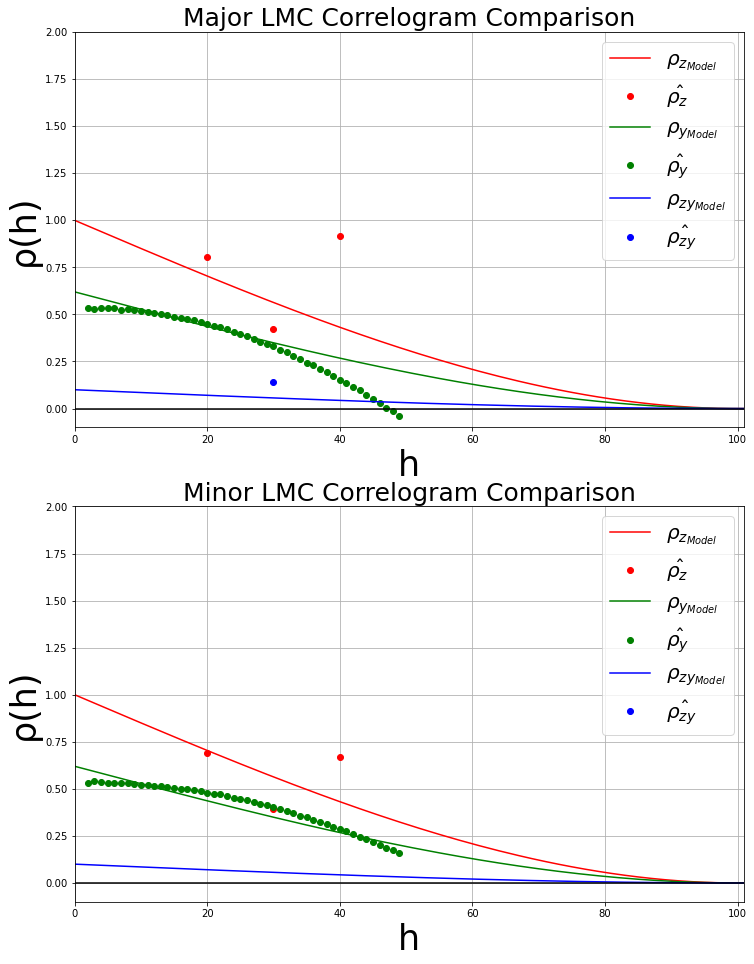

In [413]:
labels_MM = ['$ρ_{z_{Model}}$', '$ρ_{y_{Model}}$', '$ρ_{zy_{Model}}$']
varg_type = 2  # See Correlogram Functions
k = 0
cy = np.zeros(shape=(LENGTH + 1))
cz_True = np.zeros(shape=(LENGTH + 1))
czy = np.zeros(shape=(LENGTH + 1))
nstruct = dict_secondary_LMC["nstruct"]
fig, axes = plt.subplots(2, 1, figsize=(12, 16))
for s,Dir in enumerate(["Major","Minor"]):
    for h in range(0, 101):

        cy[h]= C_Y_alternate(np.matrix(h), np.matrix(h), varg_type,dict_secondary_LMC, nstruct )

        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type,dict_primary_LMC, nstruct )

        czy[h]= C_ZY(np.matrix(h), np.matrix(h),varg_type,dict_cross_LMC, nstruct)

        H[h] = h
    MM_vargs = [cz_True, cy, czy]
    
    for i in range(0, 3):
        axes[s].plot(H, MM_vargs[i], color=colors[i], label=labels_MM[i])
        if (i + 1) < 4:
            var = locals()["varc_{}".format(i + 1)]
            axes[s].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "o",
                color=colors[i],
                label=labels_1[i],
            )

    axes[s].plot(H, ones, color="Black")
    axes[s].grid()
    axes[s].set_xlim(0, 101)
    axes[s].set_ylim(-0.1, 2)
    axes[s].set_ylabel("\u03C1(h)", size=35)
    axes[s].set_xlabel("h", size=35)
    axes[s].set_title(
        Dir+" LMC Correlogram Comparison",
        size=25,
    )
    axes[s].legend(loc="best", prop={"size": 20})
    varg_type = varg_type + 1
    k += 1

# Cokriging

In [414]:
Mean_Z = np.average(Primary["Primary"])
STD_Z = 1.0
print(Mean_Z)
print(STD_Z)

3.3306690738754695e-17
1.0


In [415]:
Mean_Y = np.average(Primary["Secondary"])
STD_Y =  1.0
print(Mean_Y)
print(STD_Y)

0.0
1.0


## KDTree

In [416]:
from sklearn.neighbors import KDTree

In [417]:
def ech_data_kdtree(x,y,z,ech) :
    """
    Fonction qui ré-echantillonne avant l'utilisation d'un KD Tree
    """
    low_quality_secondary = pd.DataFrame()
    x_ech = x[::ech]
    low_quality_secondary["x"] = x_ech
    y_ech = y[::ech]
    low_quality_secondary["y"] = y_ech
    z_ech = z[::ech]
    low_quality_secondary["z"] = z_ech
    
    return low_quality_secondary,x_ech,y_ech,z_ech

In [418]:
##MATRICES NON ECHANTILLONEE
x = Secondary["X"].values
y = Secondary["Y"].values
z = Secondary["Secondary"].values

# MATRICES ECHANTILLONEES
ech = 1
df_kriging,x_ech,y_ech,z_ech = ech_data_kdtree(x,y,z,ech)

In [419]:
Primary.head()

,X,Y,original_z,Primary,original_zy,Secondary
0,60.0,0.0,0.931187,2.268657,1.024126,1.467267
1,70.0,60.0,0.450316,0.636417,-0.128867,-1.278337
2,20.0,0.0,0.015360,-0.839971,0.420198,0.029141
3,40.0,10.0,0.476273,0.724526,0.284888,-0.293069
4,60.0,90.0,0.051561,-0.717091,0.454994,0.112001


In [420]:
#Constitution d'un KD Tree, Primary data
datafl_XY = Primary[["X", "Y"]].values
datafl = Primary
tree = KDTree(datafl_XY)
Pred_grid_xy = np.matrix([x, y]).T

#Constitution d'un KD Tree, Secondary data
datafl_sec = Secondary
datafl_XY_2nd = Secondary[["X", "Y"]].values
tree_2nd = KDTree(datafl_XY_2nd)

### Primary Data Search for Kriging

In [421]:
len(Primary)

10

In [423]:
k_p = 10 # number of data to use
X_Y = np.zeros((len(x), k_p, 2))
X_Y_Star = np.zeros((len(x), k_p, 2))
closematrix_Primary = np.zeros((len(x), k_p))
closematrix_Secondary = np.zeros((len(x), k_p))
neardistmatrix = np.zeros((len(x), k_p))

for i in range(0, len(x)):
    nearest_dist, nearest_ind = tree.query(Pred_grid_xy[i : i + 1, :], k=k_p)
    a = nearest_ind.ravel()
    group = datafl.iloc[a, :]
    closematrix_Primary[i, :] = group["Primary"]
    closematrix_Secondary[i, :] = group["Secondary"]
    neardistmatrix[i, :] = nearest_dist
    X_Y[i, :, :] = group[["X", "Y"]]

### Secondary Data Search for Kriging

In [424]:
X_Y_2nd = np.zeros((len(x), k_p, 2))
closematrix_Secondary_2nd = np.zeros((len(x), k_p))
for i in range(0, len(x)):
    nearest_dist, nearest_ind = tree_2nd.query(
        Pred_grid_xy[i : i + 1, :], k=k_p
    )
    a = nearest_ind.ravel()
    group = datafl_sec.iloc[a, :]
    closematrix_Secondary_2nd[i, :] = group["Secondary"]
    X_Y_2nd[i, :, :] = group[["X", "Y"]]

### Recap des models de variogrammes

In [425]:
print("Premier Correlogram") 
print(dict_primary)

Premier Correlogram
{'a_max': [150.0], 'a_min': [123.0], 'cc': [0.94], 'vtype': array([1]), 'nstruct': 1}


In [426]:
print("Second Correlogram") 
print(dict_secondary)

Second Correlogram
{'a_max': [76.0], 'a_min': [106.0], 'cc': [0.63], 'vtype': array([1]), 'nstruct': 1}


In [427]:
print("Cross Correlogram") 
print(dict_cross)

Cross Correlogram
{'a_max': [4.0], 'a_min': [0.0], 'cc': [0.24], 'vtype': array([1]), 'nstruct': 1}


In [428]:
print("LMC Correlogram ") 
print(dict_LMC)

LMC Correlogram 
{'a_max': [100.0], 'a_min': [100.0], 'vtype': array([1]), 'nstruct': 1}


## Full Cokriging

In [429]:
cz = np.zeros(shape=(k_p, k_p))
czy = np.zeros(shape=(k_p, k_p))
czy_2 = np.zeros(shape=(k_p, k_p))
cy = np.zeros(shape=(k_p, k_p))
s_m = 0
sm_idx = []
est_Full_CCK = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k_p * 2), (k_p * 2)))
    # C_ZZ
    cz = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :],0,dict_primary, nstruct = 1, Azimuth = 0)
    # C_ZY
    czy = C_ZY(X_Y[z, :, :], X_Y_2nd[z, :, :], 0,dict_cross, nstruct = 1, Azimuth = 0)
    czy_2 = C_ZY(X_Y_2nd[z, :, :], X_Y[z, :, :], 0,dict_cross, nstruct = 1, Azimuth = 0)
    # C_YY
    cy = C_Y_alternate(X_Y_2nd[z, :, :], X_Y_2nd[z, :, :], 0, dict_secondary, nstruct = 1, Azimuth = 0 )
    Kriging_Matrix = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    # print(Kriging_Matrix)
    # Set up Right Hand Sides
    r = np.zeros(shape=(k_p * 2))
    k_p_weights = np.zeros(shape=(k_p * 2))
    # RHS #C_z*
    r[0:k_p] = C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1,dict_primary, nstruct = 1, Azimuth = 0 )
    # RHS #C_zy*
    r[k_p : k_p * 2] = C_ZY(
        X_Y_2nd[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1, dict_cross, nstruct = 1, Azimuth = 0)
    # Calculate Kriging Weights
    try:
        k_p_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_p_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_Full_CCK[z] = 0
    # add in mean_z
    est_Full_CCK[z] = est_Full_CCK[z] + Mean_Z
    for i in range(0, k_p):
        # add in Z_i
        est_Full_CCK[z] = (
            est_Full_CCK[z]
            + k_p_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_Full_CCK[z] = (
            est_Full_CCK[z]
            + k_p_weights[i + k_p]
            * (closematrix_Secondary_2nd[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]


ZeroDivisionError: float division by zero

## Full Cokriging with LMC

In [430]:
cz = np.zeros(shape=(k_p, k_p))
czy = np.zeros(shape=(k_p, k_p))
czy_2 = np.zeros(shape=(k_p, k_p))
cy = np.zeros(shape=(k_p, k_p))
s_m = 0
sm_idx = []
est_Full_CCK_LMC = np.zeros(shape=(len(x)))
nstruct = 1

dict_secondary_LMC
dict_primary_LMC
dict_cross_LMC

for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k_p * 2), (k_p * 2)))
    # C_ZZ
    cz = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :],0,dict_primary_LMC, nstruct ,Azimuth = 0)
    # C_ZY
    czy = C_ZY(X_Y[z, :, :], X_Y_2nd[z, :, :], 0,dict_cross_LMC, nstruct ,Azimuth = 0)
    czy_2 = C_ZY(X_Y_2nd[z, :, :], X_Y[z, :, :], 0,dict_cross_LMC, nstruct ,Azimuth = 0)
    # C_YY
    cy = C_Y_alternate(X_Y_2nd[z, :, :], X_Y_2nd[z, :, :], 0, dict_secondary_LMC, nstruct ,Azimuth = 0 )
    Kriging_Matrix = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    # print(Kriging_Matrix)
    # Set up Right Hand Sides
    r = np.zeros(shape=(k_p * 2))
    k_p_weights = np.zeros(shape=(k_p * 2))
    # RHS #C_z*
    r[0:k_p] = C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1,dict_primary_LMC, nstruct ,Azimuth = 0 )
    # RHS #C_zy*
    r[k_p : k_p * 2] = C_ZY(
        X_Y_2nd[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1, dict_cross_LMC, nstruct ,Azimuth = 0)
    # Calculate Kriging Weights
    try:
        k_p_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_p_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_Full_CCK_LMC[z] = 0
    # add in mean_z
    est_Full_CCK_LMC[z] = est_Full_CCK_LMC[z] + Mean_Z
    for i in range(0, k_p):
        # add in Z_i
        est_Full_CCK_LMC[z] = (
            est_Full_CCK_LMC[z]
            + k_p_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_Full_CCK_LMC[z] = (
            est_Full_CCK_LMC[z]
            + k_p_weights[i + k_p]
            * (closematrix_Secondary_2nd[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1259.87it/s]

There where 0 Singular Matrices


## Intrinsic Collocated Cokriging - MM2

In [431]:
k = k_p
s_m = 0
sm_idx = []
cz = np.zeros(shape=(k, k))
czy = np.zeros(shape=(k, k))
cy = np.zeros(shape=(k, k))
est_icck_MM2 = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k * 2 + 1), (k * 2 + 1)))
    # C_ZZ
    # 1
    # C_Z_MM2(X_Y[z, :, :], X_Y[z, :, :], 0, corr)
        
    cz = C_Z_MM2(X_Y[z, :, :], X_Y[z, :, :], 0,corr,dict_secondary, dict_scalling )
    # C_ZY
    # 2,#3
    # corr * C_Y(X_Y[z, :, :], X_Y[z, :, :], 0)
    czy = C_Y_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,
                                       dict_secondary, nstruct = 1)
    # C_YY
    # 4
    # C_Y(X_Y[z, :, :], X_Y[z, :, :], 0)
    cy = C_Y_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,
                                       dict_secondary, nstruct = 1)
    # Set up Right Hand Side
    # print(Kriging_Matrix.reshape(((2*k)+1),((2*k)+1)))
    Kriging_Matrix[0 : k * 2, 0 : k * 2] = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    r = np.zeros(shape=(k * 2) + 1)
    k_weights = r
    # RHS #C_z*
    # 5
    r[0:k] = C_Z_MM2(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1, corr,dict_secondary, dict_scalling )
    # RHS #C_yz*
    # 6
    r[k : k * 2] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1,
                                       dict_secondary, nstruct = 1) * corr
    )
    # RHS corr
    # 7
    r[k * 2] = corr
    # c_zy
    # 8
    Kriging_Matrix[k * 2, 0:k] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1) * corr
    )
    Kriging_Matrix[0:k, k * 2] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1) * corr
    )
    # c_y
    # 9
    Kriging_Matrix[k * 2, k : k * 2] = C_Y_alternate(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1)
    
    Kriging_Matrix[k : k * 2, k * 2] = C_Y_alternate(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1)
    
    Kriging_Matrix[k * 2, k * 2] = 1
    # Kriging_Matrix.reshape(((2*k)+1),((2*k)+1))
    # Calculate Kriging Weights
    try:
        k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_icck_MM2[z] = 0
    # add in mean_z
    est_icck_MM2[z] = est_icck_MM2[z] + Mean_Z
    # add in the Y_0
    est_icck_MM2[z] = (
        est_icck_MM2[z]
        + k_weights[k * 2] * (datafl_sec["Secondary"][z] - Mean_Y) / STD_Y
    )
    for i in range(0, k):
        # add in Z_i
        est_icck_MM2[z] = (
            est_icck_MM2[z]
            + k_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_icck_MM2[z] = (
            est_icck_MM2[z]
            + k_weights[i + k]
            * (closematrix_Secondary[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 634.38it/s]

There where 0 Singular Matrices


##  Mise en place des résultats

In [432]:
ktypes = ["SCK","LMC_SCK","ICC_MM2"]
k_est = [est_Full_CCK,
         est_Full_CCK_LMC,
         est_icck_MM2
]
ktypes_vals_dict = {}
dict_types = {}
j = 0
for i in ktypes:
    
    ktypes_vals_dict[i] = {
        "Estimate": k_est[j],
        "Mean": np.mean(k_est[j]),
        "Variance": np.var(k_est[j]),
    }
    
    df_kriging["NS_Estimate_"+i] = ktypes_vals_dict[i]["Estimate"]
    df_kriging["Estimate_"+i] = ktypes_vals_dict[i]["Estimate"]* original_std_z + original_mean_z
    j = j + 1

##  Affichage des différents cokrigeage

### MM2 vs SCK

Text(0.5, 1.0, 'SCK\nZ : 0.94 Spherical \nY : 0.63 Spherical \nZY : 0.24 Spherical \n')

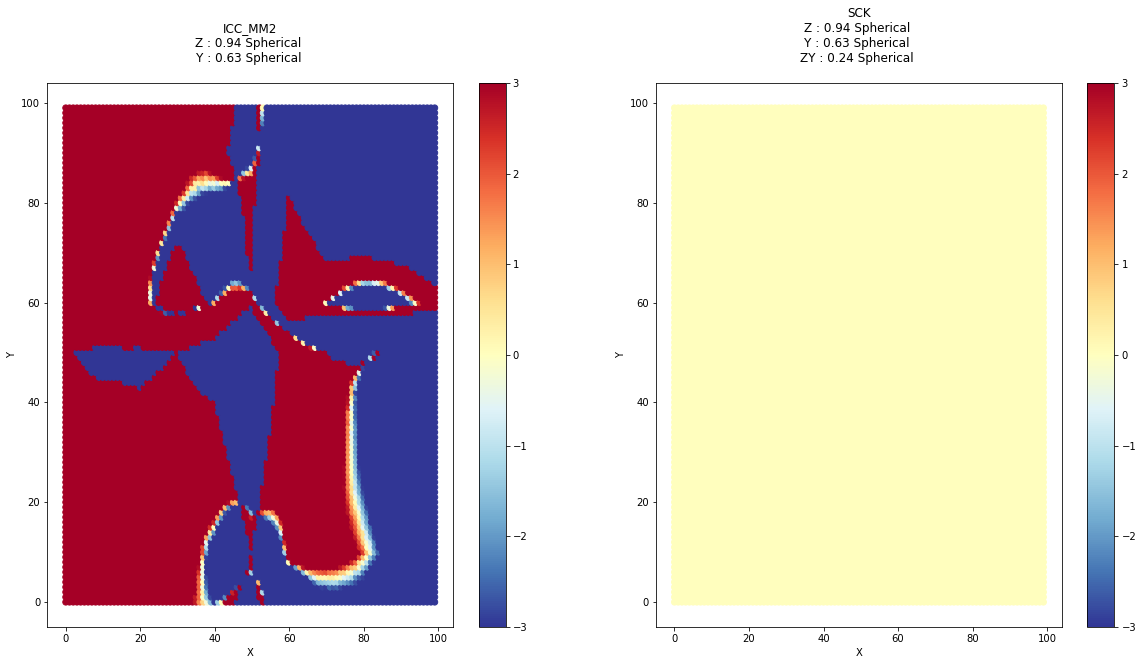

In [433]:
fig,ax=plt.subplots(1,2, figsize = (20,10))

types = "ICC_MM2"
Z = df_kriging["NS_Estimate_"+types].values
img0 = ax[0].scatter(x_ech, y_ech,c = Z,vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
# Title name Z / Y 
TITLE = ""
count = 1
for cc,vtype in zip(dict_primary["cc"],dict_primary["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_primary["cc"]) >= 2 ):
        a = 1
        TITLE += f"Z : {cc} {model} +" 
    elif len(dict_primary["cc"])<2 or count == len(dict_primary["cc"]) :
        TITLE += f"Z : {cc} {model} \n"
    else : 
        TITLE += f" {cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_secondary["cc"],dict_secondary["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_secondary["cc"]) >= 2 ):
        TITLE += f"Y : {cc} {model} +" 
    elif (len(dict_secondary["cc"])<2) or (count == len(dict_secondary["cc"])):
        TITLE += f"Y : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
ax[0].set_title(types +'\n'+TITLE)
fig.colorbar(img0, ax=ax[0])

# ----------------------------------------------------------------------------------------------------------
types = "SCK"
Z = df_kriging["NS_Estimate_"+types].values
img0 = ax[1].scatter(x_ech, y_ech,c = Z,vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
fig.colorbar(img0, ax=ax[1])

# Title name Z / Y / ZY
TITLE = ""
count = 1
for cc,vtype in zip(dict_primary["cc"],dict_primary["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_primary["cc"]) >= 2 ):
        a = 1
        TITLE += f"Z : {cc} {model} +" 
    elif len(dict_primary["cc"])<2 or count == len(dict_primary["cc"]) :
        TITLE += f"Z : {cc} {model} \n"
    else : 
        TITLE += f" {cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_secondary["cc"],dict_secondary["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_secondary["cc"]) >= 2 ):
        TITLE += f"Y : {cc} {model} +" 
    elif (len(dict_secondary["cc"])<2) or (count == len(dict_secondary["cc"])):
        TITLE += f"Y : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_cross["cc"],dict_cross["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_cross["cc"]) >= 2) :
        TITLE += f"ZY : {cc} {model} +" 
    elif len(dict_cross["cc"])<2 or count == len(dict_cross["cc"]):
        TITLE += f"ZY : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
ax[1].set_title(types +'\n'+TITLE)

### LMC

Text(0.5, 1.0, 'LMC_SCK\nZ : 1.0 Spherical \nY : 0.62 Spherical \nZY : 0.1 Spherical \n')

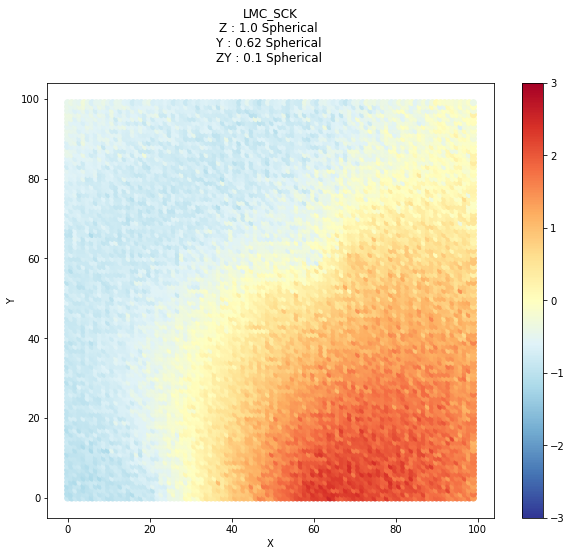

In [437]:
# Aperçu de la zone d'étude 
fig,ax=plt.subplots(1,1, figsize = (10,8))
types = "LMC_SCK"
Z = df_kriging["NS_Estimate_"+types].values
img0 = ax.scatter(x_ech, y_ech,c = Z,vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax.set_xlabel('X')
ax.set_ylabel('Y')
fig.colorbar(img0, ax=ax)

# Title name Z / Y / ZY
TITLE = ""
count = 1
for cc,vtype in zip(dict_primary_LMC["cc"],dict_primary_LMC["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_primary_LMC["cc"]) >= 2 ):
        a = 1
        TITLE += f"Z : {cc} {model} +" 
    elif len(dict_primary_LMC["cc"])<2 or count == len(dict_primary_LMC["cc"]) :
        TITLE += f"Z : {cc} {model} \n"
    else : 
        TITLE += f" {cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_secondary_LMC["cc"],dict_secondary_LMC["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_secondary_LMC["cc"]) >= 2 ):
        TITLE += f"Y : {cc} {model} +" 
    elif (len(dict_secondary_LMC["cc"])<2) or (count == len(dict_secondary_LMC["cc"])):
        TITLE += f"Y : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_cross_LMC["cc"],dict_cross_LMC["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_cross_LMC["cc"]) >= 2) :
        TITLE += f"ZY : {cc} {model} +" 
    elif len(dict_cross_LMC["cc"])<2 or count == len(dict_cross_LMC["cc"]):
        TITLE += f"ZY : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
ax.set_title(types +'\n'+TITLE)

#  Comparaison des Cokriging à la fonction initiale 

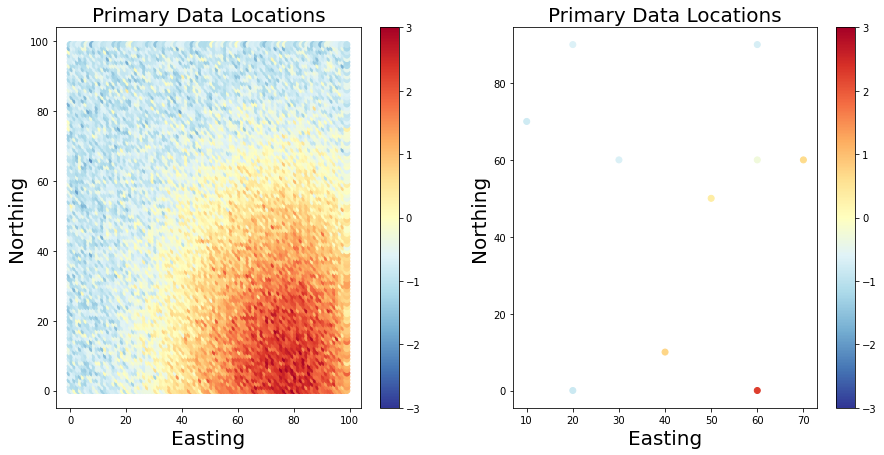

In [438]:
#Primary_truth Data Data
x, y = np.mgrid[0:0.5 * np.pi:100j, 0:0.5 * np.pi:100j]
np.random.seed(21)
mu, sigma = 0, 0.1
_field_z_truth  = fun_Primary(x,y,mu,sigma,size = 100)

Primary_truth = pd.DataFrame()
Primary_truth["X"] = xx_y.reshape(-1)
Primary_truth["Y"] = yy_y.reshape(-1)
Primary_truth["original_z"] = _field_z_truth.reshape(-1)
Primary_truth["Primary"] = (Primary_truth["original_z"] - Primary_truth["original_z"].mean()) / Primary_truth["original_z"].std()

f, ax = plt.subplots(1,2, figsize = (15,7))

img0 = ax[0].scatter(Primary_truth["X"], Primary_truth["Y"], c=Primary_truth["Primary"].values,
                     vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax[0].set_title("Primary Data Locations", size=20)
ax[0].set_xlabel("Easting", size=20)
ax[0].set_ylabel("Northing", size=20)
fig.colorbar(img0, ax=ax[0])

img0 = ax[1].scatter(Primary["X"], Primary["Y"], c=Primary["Primary"].values,
                     vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax[1].set_title("Primary Data Locations", size=20)
ax[1].set_xlabel("Easting", size=20)
ax[1].set_ylabel("Northing", size=20)
fig.colorbar(img0, ax=ax[1])


### Différence entre LMC / fonction initiale

Text(0.5, 1.0, "Différence entre les valeurs issus d'un cokriging LMC et de la fonction initiale \n RMSE = 0.42")

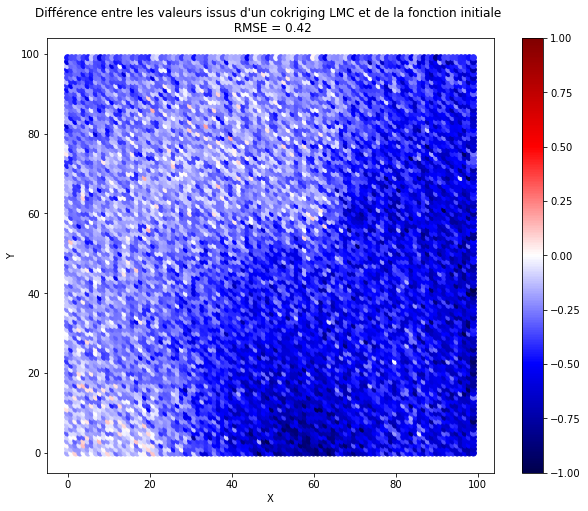

In [439]:
# Aperçu de la zone d'étude 
fig,ax=plt.subplots(1,1, figsize = (10,8))
types = "LMC_SCK"
#Différence entre les valeurs originales et non transformées
Z_ck = df_kriging["Estimate_"+types].values 
Z_truth = Primary_truth["original_z"].values
Z = Z_truth - Z_ck
RMSE = np.sqrt(mean_squared_error(Z_ck,Z_truth))
img0 = ax.scatter(x_ech, y_ech,c = Z,vmin = -1, vmax = 1, cmap = "seismic")
ax.set_xlabel('X')
ax.set_ylabel('Y')
fig.colorbar(img0, ax=ax)
Title = "Différence entre les valeurs issus d'un cokriging LMC et de la fonction initiale \n RMSE = " + "{:.2f}".format(RMSE)
ax.set_title(Title)